# Data downlad and Exploration

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# -----------------------------
# 1. Download S&P 500 data
# -----------------------------
data = yf.download("^GSPC", start="2000-01-01")

# Keep adjusted close
data['price'] = data['Close'].astype(float)

# -----------------------------
# 2. Compute returns
# -----------------------------
data['return'] = data['price'].pct_change()

# -----------------------------
# 3. Volatility regime
# -----------------------------
# 20-day rolling volatility
data['vol_20'] = data['return'].rolling(20).std()

# Define volatility regimes using percentiles
low_vol = data['vol_20'].quantile(0.3)
high_vol = data['vol_20'].quantile(0.7)

def volatility_regime(vol):
    if vol < low_vol:
        return 'low_vol'
    elif vol > high_vol:
        return 'high_vol'
    else:
        return 'mid_vol'

data['vol_regime'] = data['vol_20'].apply(volatility_regime)

# -----------------------------
# 4. Trend regime
# -----------------------------
# Moving averages
data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()

def trend_regime(row):
    if row['ma_50'] > row['ma_200']:
        return 'uptrend'
    elif row['ma_50'] < row['ma_200']:
        return 'downtrend'
    else:
        return 'sideways'

data['trend_regime'] = 'sideways'

data.loc[data['ma_50'] > data['ma_200'], 'trend_regime'] = 'uptrend'
data.loc[data['ma_50'] < data['ma_200'], 'trend_regime'] = 'downtrend'

# -----------------------------
# 5. Drawdown regime
# -----------------------------
# Rolling maximum
data['rolling_max'] = data['price'].cummax()

# Drawdown
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

def drawdown_regime(dd):
    if dd < -0.2:
        return 'crisis'
    elif dd < -0.1:
        return 'stress'
    else:
        return 'normal'

data['drawdown_regime'] = data['drawdown'].apply(drawdown_regime)

# -----------------------------
# 6. Clean final dataset
# -----------------------------
data = data.dropna()

print(data[['return', 'vol_regime', 'trend_regime', 'drawdown_regime']].head())


/tmp/ipykernel_18/1189855212.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="2000-01-01")
[*********************100%***********************]  1 of 1 completed

Price         return vol_regime trend_regime drawdown_regime
Ticker                                                      
Date                                                        
2000-10-16  0.000327   high_vol      uptrend          stress
2000-10-17 -0.017932   high_vol      uptrend          stress
2000-10-18 -0.005808   high_vol      uptrend          stress
2000-10-19  0.034743   high_vol      uptrend          normal
2000-10-20  0.005883   high_vol      uptrend          normal


In [2]:
# -----------------------------
# Risk-free rate (approximation)
# -----------------------------
# Assume 3% annual → convert to daily
annual_rf = 0.03
daily_rf = annual_rf / 252

data['rf'] = daily_rf

# Excess return
data['excess_return'] = data['return'] - data['rf']

In [3]:
# Predict next day's excess return direction
data['target'] = (data['excess_return'].shift(-1) > 0).astype(int)

data = data.dropna()

In [4]:
# Momentum features
data['ret_5'] = data['return'].rolling(5).mean()
data['ret_10'] = data['return'].rolling(10).mean()
data['ret_20'] = data['return'].rolling(20).mean()

# Volatility features
data['vol_10'] = data['return'].rolling(10).std()
data['vol_30'] = data['return'].rolling(30).std()

# Trend strength
data['ma_ratio'] = data['ma_50'] / data['ma_200'] - 1

data = data.dropna()


In [5]:
from sklearn.model_selection import train_test_split

features = [
    'ret_5', 'ret_10', 'ret_20',
    'vol_10', 'vol_30',
    'ma_ratio'
]

X = data[features]
y = data['target']

# 80% train, 20% test (time-ordered)
split = int(0.8 * len(data))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [7]:
# Probability that excess return > 0
data.loc[X_test.index, 'prob_up'] = model.predict_proba(X_test)[:, 1]

In [8]:
# Base allocation around 1
data['allocation'] = 1 + (data['prob_up'] - 0.5) * 2

# Reduce exposure when volatility is high
target_vol = data['vol_30'].median()
data['allocation'] *= target_vol / data['vol_30']

# Keep allocation within bounds
data['allocation'] = data['allocation'].clip(0, 2)

In [9]:
data['strategy_return'] = data['allocation'].shift(1) * data['return']

In [10]:
data['buy_hold_return'] = data['return']

In [11]:
data['allocation']  # your ML-based allocation
data['return']      # daily S&P 500 return

Date
2000-11-27    0.005366
2000-11-28   -0.009548
2000-11-29    0.004371
2000-11-30   -0.020105
2000-12-01    0.000213
                ...   
2026-02-17    0.001031
2026-02-18    0.005566
2026-02-19   -0.002822
2026-02-20    0.006940
2026-02-23   -0.010386
Name: return, Length: 6346, dtype: float64

# Experimentation - testing and refining trading strategies

In [12]:
# Define Sharpe function
def sharpe_ratio(returns, rf=0):
    excess = returns - rf
    return excess.mean() / (excess.std() + 1e-9) * np.sqrt(252)  # annualized

# Evaluate by trend regime
trend_perf = data.groupby('trend_regime').apply(
    lambda x: pd.Series({
        'strategy_mean': x['strategy_return'].mean(),
        'strategy_vol': x['strategy_return'].std(),
        'strategy_sharpe': sharpe_ratio(x['strategy_return']),
        'market_mean': x['buy_hold_return'].mean(),
        'market_vol': x['buy_hold_return'].std(),
        'market_sharpe': sharpe_ratio(x['buy_hold_return'])
    })
)

print(trend_perf)

              strategy_mean  strategy_vol  strategy_sharpe  market_mean  \
trend_regime                                                              
downtrend          0.000301      0.008311         0.575374     0.000150   
uptrend            0.000517      0.009932         0.826948     0.000405   

              market_vol  market_sharpe  
trend_regime                             
downtrend       0.016769       0.141827  
uptrend         0.009554       0.672456  


/tmp/ipykernel_18/2399251116.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_perf = data.groupby('trend_regime').apply(


In [13]:
drawdown_perf = data.groupby('drawdown_regime').apply(
    lambda x: pd.Series({
        'strategy_mean': x['strategy_return'].mean(),
        'strategy_vol': x['strategy_return'].std(),
        'strategy_sharpe': sharpe_ratio(x['strategy_return']),
        'market_mean': x['buy_hold_return'].mean(),
        'market_vol': x['buy_hold_return'].std(),
        'market_sharpe': sharpe_ratio(x['buy_hold_return'])
    })
)

print(drawdown_perf)

                 strategy_mean  strategy_vol  strategy_sharpe  market_mean  \
drawdown_regime                                                              
crisis               -0.001748      0.008147        -3.405589    -0.000253   
normal                0.000737      0.009539         1.227221     0.000793   
stress                0.000018      0.010018         0.028900    -0.000009   

                 market_vol  market_sharpe  
drawdown_regime                             
crisis             0.016572      -0.242550  
normal             0.008243       1.527950  
stress             0.012755      -0.011643  


/tmp/ipykernel_18/4197741066.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drawdown_perf = data.groupby('drawdown_regime').apply(


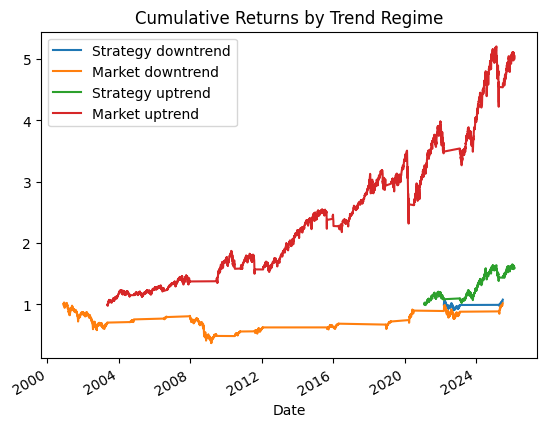

In [14]:
import matplotlib.pyplot as plt

# Cumulative returns by regime
for regime in data['trend_regime'].unique():
    subset = data[data['trend_regime'] == regime]
    (1 + subset['strategy_return']).cumprod().plot(label=f'Strategy {regime}')
    (1 + subset['buy_hold_return']).cumprod().plot(label=f'Market {regime}')

plt.legend()
plt.title("Cumulative Returns by Trend Regime")
plt.show()

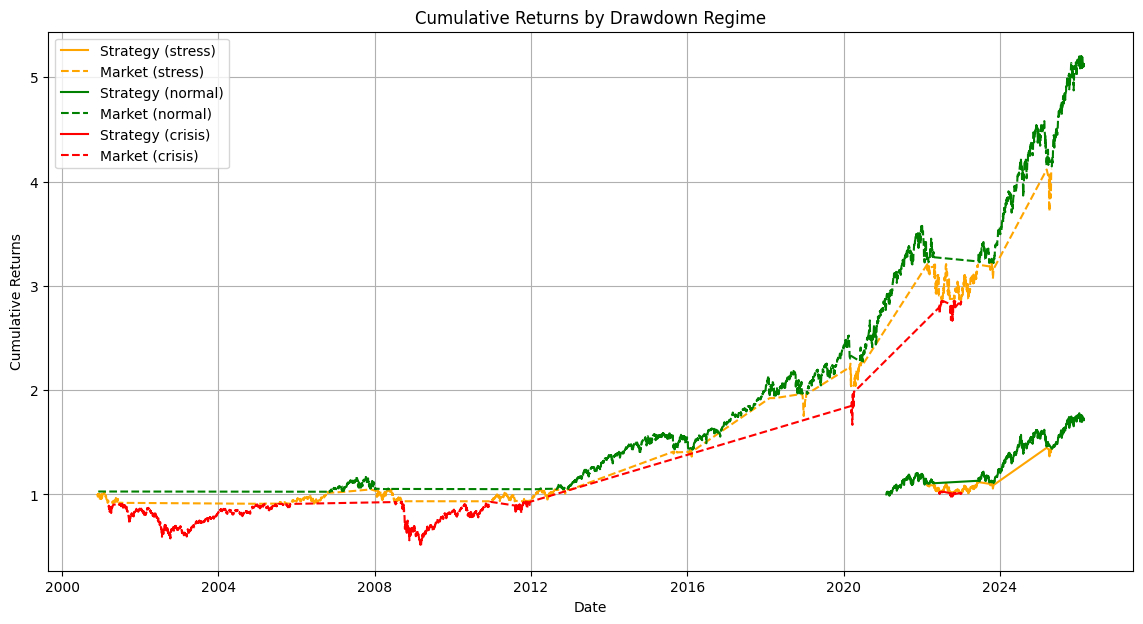

In [15]:
import matplotlib.pyplot as plt

# Ensure dates are the index (for plotting)
data.index = pd.to_datetime(data.index)

# Compute cumulative returns
data['cum_strategy'] = (1 + data['strategy_return']).cumprod()
data['cum_market'] = (1 + data['buy_hold_return']).cumprod()

# Define colors for regimes
colors = {
    'normal': 'green',
    'stress': 'orange',
    'crisis': 'red'
}

plt.figure(figsize=(14, 7))

# Plot each drawdown regime separately
for regime in data['drawdown_regime'].unique():
    subset = data[data['drawdown_regime'] == regime]
    plt.plot(subset.index, subset['cum_strategy'], 
             label=f'Strategy ({regime})', color=colors.get(regime, 'blue'), linestyle='-')
    plt.plot(subset.index, subset['cum_market'], 
             label=f'Market ({regime})', color=colors.get(regime, 'blue'), linestyle='--')

plt.title('Cumulative Returns by Drawdown Regime')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_18/3297850304.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_regime = data.groupby(regime_col).apply(


                 strategy_mean  strategy_vol  strategy_sharpe  \
drawdown_regime                                                 
crisis               -0.001748      0.008147        -3.405589   
normal                0.000737      0.009539         1.227221   
stress                0.000018      0.010018         0.028900   

                 strategy_sortino  strategy_mdd  market_mean  market_vol  \
drawdown_regime                                                            
crisis                  -6.172217     -0.085079    -0.000253    0.016572   
normal                   1.580225     -0.114564     0.000793    0.008243   
stress                   0.041322     -0.130969    -0.000009    0.012755   

                 market_sharpe  market_sortino  market_mdd  
drawdown_regime                                             
crisis               -0.242550       -0.314981   -0.578863  
normal                1.527950        2.028602   -0.098780  
stress               -0.011643       -0.015978   

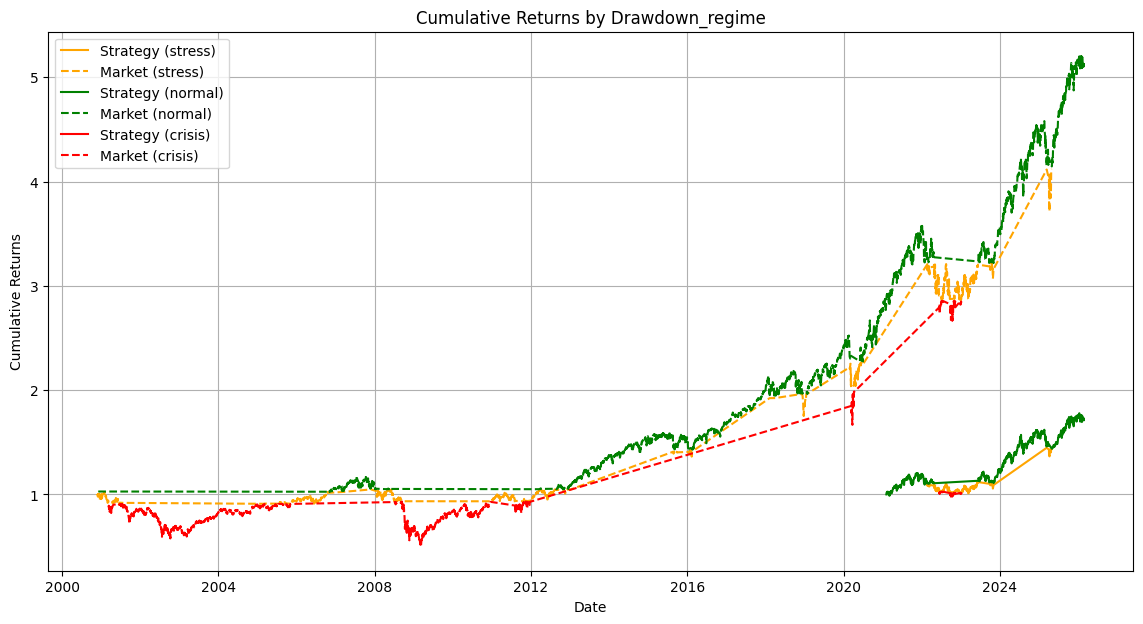

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Step 0: Assumptions
# -----------------------------
# data already has:
# 'strategy_return' : ML strategy daily return
# 'buy_hold_return' : market daily return (simple buy-and-hold)
# 'trend_regime' or 'drawdown_regime' : categorical regime
# -----------------------------

# 1. Risk-adjusted metrics

def sharpe_ratio(returns, rf=0):
    """Annualized Sharpe ratio"""
    excess = returns - rf
    return excess.mean() / (excess.std() + 1e-9) * np.sqrt(252)

def sortino_ratio(returns, rf=0):
    """Annualized Sortino ratio"""
    excess = returns - rf
    downside = returns[returns < rf]
    return excess.mean() / (downside.std() + 1e-9) * np.sqrt(252)

def max_drawdown(cum_returns):
    """Maximum drawdown from cumulative returns"""
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()

# Compute cumulative returns
data['cum_strategy'] = (1 + data['strategy_return']).cumprod()
data['cum_market'] = (1 + data['buy_hold_return']).cumprod()

# Choose regime: example for drawdown_regime
regime_col = 'drawdown_regime'

# 2. Evaluate metrics by regime
metrics_by_regime = data.groupby(regime_col).apply(
    lambda x: pd.Series({
        'strategy_mean': x['strategy_return'].mean(),
        'strategy_vol': x['strategy_return'].std(),
        'strategy_sharpe': sharpe_ratio(x['strategy_return']),
        'strategy_sortino': sortino_ratio(x['strategy_return']),
        'strategy_mdd': max_drawdown((1 + x['strategy_return']).cumprod()),
        'market_mean': x['buy_hold_return'].mean(),
        'market_vol': x['buy_hold_return'].std(),
        'market_sharpe': sharpe_ratio(x['buy_hold_return']),
        'market_sortino': sortino_ratio(x['buy_hold_return']),
        'market_mdd': max_drawdown((1 + x['buy_hold_return']).cumprod())
    })
)

print(metrics_by_regime)

# 3. Plot cumulative returns by regime

plt.figure(figsize=(14,7))

colors = {
    'normal': 'green',
    'stress': 'orange',
    'crisis': 'red'
}

for regime in data[regime_col].unique():
    subset = data[data[regime_col] == regime]
    plt.plot(subset.index, subset['cum_strategy'], label=f'Strategy ({regime})', 
             color=colors.get(regime,'blue'), linestyle='-')
    plt.plot(subset.index, subset['cum_market'], label=f'Market ({regime})', 
             color=colors.get(regime,'blue'), linestyle='--')

plt.title(f'Cumulative Returns by {regime_col.capitalize()}')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from scipy.stats import ttest_rel

# Paired t-test for daily returns
returns = data[['strategy_return','buy_hold_return']].dropna()
t_stat, p_value = ttest_rel(returns['strategy_return'], returns['buy_hold_return'])
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

T-statistic: -0.3629, p-value: 0.7167


In [18]:
from scipy.stats import ttest_rel

def t_test_by_regime(data, regime_col, strategy_col='strategy_return', market_col='buy_hold_return'):
    """
    Perform paired t-test for strategy vs market returns by regime.
    
    Parameters:
    - data: DataFrame containing returns and regime column
    - regime_col: column name for regime (e.g., 'drawdown_regime', 'trend_regime')
    - strategy_col: strategy return column name
    - market_col: market return column name
    
    Returns:
    - DataFrame with T-statistic and p-value per regime
    """
    results = []

    for regime in data[regime_col].unique():
        # Subset by regime and drop NaNs
        subset = data[data[regime_col] == regime][[strategy_col, market_col]].dropna()
        
        # Check for constant series
        if subset[strategy_col].std() == 0 or subset[market_col].std() == 0:
            results.append({
                'regime': regime,
                't_stat': np.nan,
                'p_value': np.nan,
                'note': 'Constant returns, t-test undefined'
            })
            continue
        
        # Paired t-test
        t_stat, p_value = ttest_rel(subset[strategy_col], subset[market_col])
        results.append({
            'regime': regime,
            't_stat': t_stat,
            'p_value': p_value,
            'note': ''
        })

    return pd.DataFrame(results)

# -----------------------------
# Example usage
# -----------------------------

# For drawdown regime
drawdown_test = t_test_by_regime(data, 'drawdown_regime')
print(drawdown_test)

# For trend regime
trend_test = t_test_by_regime(data, 'trend_regime')
print(trend_test)

   regime    t_stat   p_value note
0  stress -0.604705  0.545870     
1  normal -0.733421  0.463486     
2  crisis  1.372013  0.175630     
      regime    t_stat   p_value note
0  downtrend -0.646443  0.518530     
1    uptrend  0.144081  0.885466     


In [19]:
import numpy as np
import pandas as pd

def bootstrap_ci(data, strategy_col='strategy_return', market_col='buy_hold_return', 
                 regime_col=None, n_boot=10000, ci=95, seed=42):
    """
    Compute bootstrap confidence intervals for strategy excess returns over market.
    
    Parameters:
    - data: DataFrame containing returns
    - strategy_col: column name for strategy returns
    - market_col: column name for market returns
    - regime_col: optional column name for grouping (e.g., drawdown_regime)
    - n_boot: number of bootstrap samples
    - ci: confidence level (default 95%)
    - seed: random seed for reproducibility
    
    Returns:
    - DataFrame with mean excess return and confidence intervals per regime (or overall)
    """
    np.random.seed(seed)
    
    results = []

    if regime_col is not None:
        groups = data[regime_col].unique()
    else:
        groups = [None]
    
    for group in groups:
        if group is not None:
            subset = data[data[regime_col] == group][[strategy_col, market_col]].dropna()
        else:
            subset = data[[strategy_col, market_col]].dropna()
        
        # Compute daily excess return
        excess = subset[strategy_col] - subset[market_col]
        boot_means = []
        
        # Bootstrap sampling
        for _ in range(n_boot):
            sample = excess.sample(frac=1, replace=True)
            boot_means.append(sample.mean())
        
        # Confidence intervals
        lower = np.percentile(boot_means, (100 - ci)/2)
        upper = np.percentile(boot_means, 100 - (100 - ci)/2)
        mean_excess = np.mean(boot_means)
        
        results.append({
            'regime': group if group is not None else 'overall',
            'mean_excess': mean_excess,
            f'{ci}%_ci_lower': lower,
            f'{ci}%_ci_upper': upper
        })
    
    return pd.DataFrame(results)

# -----------------------------
# Example usage
# -----------------------------

# Overall bootstrap CI
overall_ci = bootstrap_ci(data)
print("Overall excess return CI:")
print(overall_ci)

# By drawdown regime
drawdown_ci = bootstrap_ci(data, regime_col='drawdown_regime')
print("\nBootstrap CI by drawdown regime:")
print(drawdown_ci)

# By trend regime
trend_ci = bootstrap_ci(data, regime_col='trend_regime')
print("\nBootstrap CI by trend regime:")
print(trend_ci)


Overall excess return CI:
    regime  mean_excess  95%_ci_lower  95%_ci_upper
0  overall    -0.000042     -0.000276       0.00019

Bootstrap CI by drawdown regime:
   regime  mean_excess  95%_ci_lower  95%_ci_upper
0  stress    -0.000237     -0.001008      0.000499
1  normal    -0.000070     -0.000265      0.000115
2  crisis     0.001390     -0.000529      0.003328

Bootstrap CI by trend regime:
      regime  mean_excess  95%_ci_lower  95%_ci_upper
0  downtrend    -0.000258     -0.001014      0.000505
1    uptrend     0.000015     -0.000195      0.000217


In [20]:
print(data.head())

Price             Close         High          Low         Open      Volume  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC   
Date                                                                         
2000-11-27  1348.969971  1362.500000  1341.770020  1341.770020   946100000   
2000-11-28  1336.089966  1358.810059  1334.969971  1348.969971  1028200000   
2000-11-29  1341.930054  1352.380005  1329.280029  1336.089966   402100000   
2000-11-30  1314.949951  1341.910034  1294.900024  1341.910034  1186530000   
2000-12-01  1315.229980  1334.670044  1307.020020  1314.949951  1195200000   

Price             price    return    vol_20 vol_regime        ma_50  ...  \
Ticker                                                               ...   
Date                                                                 ...   
2000-11-27  1348.969971  0.005366  0.013398   high_vol  1398.142395  ...   
2000-11-28  1336.089966 -0.009548  0.013048   high_vol  1395.973994  ..

In [21]:
 #Flatten MultiIndex columns
data.columns = ['_'.join([str(c) for c in col if c]) if isinstance(col, tuple) else col for col in data.columns]

# Check column names
print(data.columns)

Index(['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC',
       'price', 'return', 'vol_20', 'vol_regime', 'ma_50', 'ma_200',
       'trend_regime', 'rolling_max', 'drawdown', 'drawdown_regime', 'rf',
       'excess_return', 'target', 'ret_5', 'ret_10', 'ret_20', 'vol_10',
       'vol_30', 'ma_ratio', 'prob_up', 'allocation', 'strategy_return',
       'buy_hold_return', 'cum_strategy', 'cum_market'],
      dtype='object')


In [22]:
# Drop rows where either price, strategy_return, or buy_hold_return is NaN
required_cols = ['strategy_return', 'buy_hold_return', 'price']
data_clean = data.dropna(subset=required_cols)

# Reset index (optional, for convenience)
data_clean = data_clean.reset_index(drop=False)

print(f"Original rows: {len(data)}, After dropping NaNs: {len(data_clean)}")
print(data_clean.head())

Original rows: 6346, After dropping NaNs: 1269
        Date  Close_^GSPC   High_^GSPC    Low_^GSPC   Open_^GSPC  \
0 2021-02-03  3830.169922  3847.510010  3816.679932  3840.270020   
1 2021-02-04  3871.739990  3872.419922  3836.659912  3836.659912   
2 2021-02-05  3886.830078  3894.560059  3874.929932  3878.300049   
3 2021-02-08  3915.590088  3915.770020  3892.590088  3892.590088   
4 2021-02-09  3911.229980  3918.350098  3902.639893  3910.489990   

   Volume_^GSPC        price    return    vol_20 vol_regime  ...    ret_20  \
0    4864870000  3830.169922  0.001009  0.010812    mid_vol  ...  0.001424   
1    4879240000  3871.739990  0.010853  0.010979    mid_vol  ...  0.001681   
2    4879470000  3886.830078  0.003897  0.010553    mid_vol  ...  0.001134   
3    4648360000  3915.590088  0.007399  0.010603    mid_vol  ...  0.001229   
4    4568320000  3911.229980 -0.001114  0.010461    mid_vol  ...  0.001501   

     vol_10    vol_30  ma_ratio   prob_up allocation  strategy_return  \
0 

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

# -----------------------------
# Helper functions
# -----------------------------
def sharpe_ratio(returns, risk_free=0):
    return (returns.mean() - risk_free) / returns.std() if returns.std() != 0 else np.nan

def sortino_ratio(returns, risk_free=0):
    neg_returns = returns[returns < 0]
    downside_std = neg_returns.std()
    return (returns.mean() - risk_free) / downside_std if downside_std != 0 else np.nan

def max_drawdown(prices):
    cum_max = prices.cummax()
    drawdown = (prices - cum_max) / cum_max
    return drawdown.min()

def bootstrap_ci(excess_returns, n_boot=10000, ci=95, seed=42):
    np.random.seed(seed)
    boot_means = [excess_returns.sample(frac=1, replace=True).mean() for _ in range(n_boot)]
    lower = np.percentile(boot_means, (100 - ci)/2)
    upper = np.percentile(boot_means, 100 - (100 - ci)/2)
    mean_excess = np.mean(boot_means)
    return mean_excess, lower, upper

def t_test_returns(strategy_returns, market_returns):
    if strategy_returns.std() == 0 or market_returns.std() == 0:
        return np.nan, np.nan
    return ttest_rel(strategy_returns, market_returns)

# -----------------------------
# Consolidated metrics by regime
# -----------------------------
def metrics_by_regime(data, regime_col, strategy_col='strategy_return', market_col='buy_hold_return', price_col='price'):
    results = []
    
    for regime in data[regime_col].unique():
        # Compute daily returns if not already present
        if 'strategy_return' not in data.columns:
    # Example: simple strategy returns based on allocation (replace with your ML signal if available)
          data['strategy_return'] = data['strategy_alloc'].shift(1) * data['price'].pct_change()

        if 'buy_hold_return' not in data.columns:
          data['buy_hold_return'] = data['price'].pct_change()

#      Fill any missing values
        data = data.dropna(subset=['strategy_return'])
        subset = data[data[regime_col] == regime].dropna(subset=[strategy_col, market_col, price_col])
        if len(subset) == 0:
            continue
        
        # Daily returns
        s_returns = subset[strategy_col]
        m_returns = subset[market_col]
        prices = subset[price_col]
        
        # Risk-adjusted metrics
        s_sharpe = sharpe_ratio(s_returns)
        s_sortino = sortino_ratio(s_returns)
        s_vol = s_returns.std()
        s_mdd = max_drawdown(prices)
        
        m_sharpe = sharpe_ratio(m_returns)
        m_sortino = sortino_ratio(m_returns)
        m_vol = m_returns.std()
        
        # Bootstrap CI
        excess = s_returns - m_returns
        mean_excess, ci_lower, ci_upper = bootstrap_ci(excess)
        
        # Paired t-test
        t_stat, p_value = t_test_returns(s_returns, m_returns)
        
        results.append({
            'regime': regime,
            'strategy_mean': s_returns.mean(),
            'strategy_vol': s_vol,
            'strategy_sharpe': s_sharpe,
            'strategy_sortino': s_sortino,
            'strategy_mdd': s_mdd,
            'market_mean': m_returns.mean(),
            'market_vol': m_vol,
            'market_sharpe': m_sharpe,
            'market_sortino': m_sortino,
            'mean_excess': mean_excess,
            '95%_ci_lower': ci_lower,
            '95%_ci_upper': ci_upper,
            't_stat': t_stat,
            'p_value': p_value
        })
    
    return pd.DataFrame(results)

# -----------------------------
# Example usage
# -----------------------------

# By drawdown regime
drawdown_metrics = metrics_by_regime(data, 'drawdown_regime')
print("Drawdown regime metrics:\n", drawdown_metrics)

# By trend regime
trend_metrics = metrics_by_regime(data, 'trend_regime')
print("\nTrend regime metrics:\n", trend_metrics)


Drawdown regime metrics:
    regime  strategy_mean  strategy_vol  strategy_sharpe  strategy_sortino  \
0  stress       0.000018      0.010018         0.001821          0.002603   
1  normal       0.000737      0.009539         0.077308          0.099545   
2  crisis      -0.001748      0.008147        -0.214532         -0.388813   

   strategy_mdd  market_mean  market_vol  market_sharpe  market_sortino  \
0     -0.108391     0.000253    0.015416       0.016397        0.023962   
1     -0.099817     0.000809    0.008200       0.098685        0.139081   
2     -0.066388    -0.003123    0.015498      -0.201525       -0.343994   

   mean_excess  95%_ci_lower  95%_ci_upper    t_stat   p_value  
0    -0.000237     -0.001008      0.000499 -0.604705  0.545870  
1    -0.000071     -0.000267      0.000115 -0.733421  0.463486  
2     0.001359     -0.000588      0.003324  1.372013  0.175630  

Trend regime metrics:
       regime  strategy_mean  strategy_vol  strategy_sharpe  strategy_sortino  \


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:44:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


            Close_^GSPC   High_^GSPC    Low_^GSPC   Open_^GSPC  Volume_^GSPC  \
Date                                                                           
2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000     931800000   
2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971    1009000000   
2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044    1085500000   
2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985    1092300000   
2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951    1225200000   

                  price  
Date                     
2000-01-03  1455.219971  
2000-01-04  1399.420044  
2000-01-05  1402.109985  
2000-01-06  1403.449951  
2000-01-07  1441.469971  


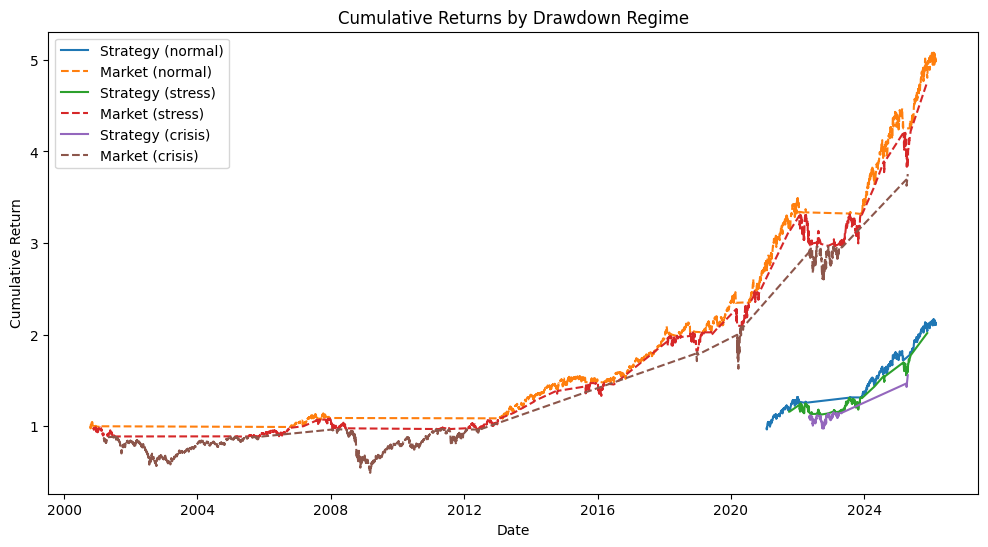

Drawdown Regime Metrics:
    regime  strategy_mean  strategy_vol  strategy_sharpe  strategy_sortino  \
0  normal       0.001167      0.008706         2.128452          2.895836   
1  stress       0.000568      0.014800         0.609741          1.023958   
2  crisis      -0.001248      0.016679        -1.188242         -1.718940   

   strategy_mdd  market_mean  market_vol  market_sharpe  market_sortino  \
0     -0.056024     0.001037    0.007765       2.119413        2.918257   
1     -0.152355     0.000284    0.012773       0.352996        0.549072   
2     -0.203177    -0.001236    0.015421      -1.271994       -1.877326   

     t_stat   p_value  mean_excess  95%_ci_lower  95%_ci_upper  
0  2.592899  0.009701     0.000131      0.000029      0.000225  
1  1.637772  0.102431     0.000284     -0.000013      0.000651  
2 -0.068839  0.945191    -0.000013     -0.000391      0.000370  

Trend Regime Metrics:
       regime  strategy_mean  strategy_vol  strategy_sharpe  strategy_sortino  \


In [24]:
# ==============================
# FULL PIPELINE: XGBoost Strategy
# ==============================

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# ------------------------------
# Step 1: Fetch S&P500 Data
# ------------------------------
# Download S&P500 data
data = yf.download("^GSPC", start="2000-01-01", auto_adjust=True)

# If columns are MultiIndex (happens when Ticker is included)
if isinstance(data.columns, pd.MultiIndex):
    # Flatten MultiIndex
    data.columns = ['_'.join([str(c) for c in col if c]) for col in data.columns]

# Use 'Close' (or 'Close_^GSPC') as price
if 'Close' in data.columns:
    data['price'] = data['Close'].astype(float)
elif 'Close_^GSPC' in data.columns:
    data['price'] = data['Close_^GSPC'].astype(float)
else:
    raise KeyError("No 'Close' column found in data")

# Inspect
print(data.head())

# ------------------------------
# Step 2: Compute returns & features
# ------------------------------
data['return'] = data['price'].pct_change()
data['vol_10'] = data['return'].rolling(10).std()
data['vol_20'] = data['return'].rolling(20).std()
data['ret_20'] = data['return'].rolling(20).mean()
data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['ma_ratio'] = data['ma_50'] / data['ma_200']

# Drop initial NaNs
data.dropna(inplace=True)

# ------------------------------
# Step 3: Define regimes
# ------------------------------
# Trend regime
def trend_regime(row):
    if row['ma_50'] > row['ma_200']:
        return 'uptrend'
    else:
        return 'downtrend'
data['trend_regime'] = data.apply(trend_regime, axis=1)

# Drawdown regime
data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

def drawdown_regime(dd):
    if dd < -0.15:
        return 'crisis'
    elif dd < -0.05:
        return 'stress'
    else:
        return 'normal'
data['drawdown_regime'] = data['drawdown'].apply(drawdown_regime)

# ------------------------------
# Step 4: Define target
# ------------------------------
data['target'] = (data['return'].shift(-1) > 0).astype(int)
data.dropna(subset=['target'], inplace=True)

# Features for ML
features = ['ret_20', 'vol_10', 'vol_20', 'ma_ratio']
X = data[features]
y = data['target']

# ------------------------------
# Step 5: Train/test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ------------------------------
# Step 6: Train XGBoost
# ------------------------------
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Predict probabilities & direction
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Add predictions to data
data.loc[X_test.index, 'pred_prob'] = y_pred_prob
data.loc[X_test.index, 'pred_direction'] = y_pred

# ------------------------------
# Step 7: Compute strategy returns
# ------------------------------
# Simple leveraged strategy: allocation = 2 * predicted prob
data['strategy_alloc'] = 2 * data['pred_prob'].shift(1)  # shift to avoid lookahead
data['strategy_return'] = data['strategy_alloc'] * data['return']
data['buy_hold_return'] = data['return']

# Cumulative returns
data['cum_strategy'] = (1 + data['strategy_return']).cumprod()
data['cum_market'] = (1 + data['buy_hold_return']).cumprod()

# ------------------------------
# Step 8: Risk-adjusted metrics
# ------------------------------
def sharpe_ratio(returns):
    return returns.mean() / returns.std() * np.sqrt(252)

def sortino_ratio(returns):
    downside = returns[returns < 0].std()
    return returns.mean() / downside * np.sqrt(252)

def max_drawdown(cum_returns):
    return (cum_returns / cum_returns.cummax() - 1).min()

# Metrics by regime
def metrics_by_regime(data, regime_col):
    rows = []
    for regime in data[regime_col].unique():
        subset = data[data[regime_col] == regime].dropna(subset=['strategy_return', 'buy_hold_return', 'price'])
        if len(subset) == 0:
            continue
        strategy_ret = subset['strategy_return']
        market_ret = subset['buy_hold_return']
        cum_strategy = (1 + strategy_ret).cumprod()
        rows.append({
            'regime': regime,
            'strategy_mean': strategy_ret.mean(),
            'strategy_vol': strategy_ret.std(),
            'strategy_sharpe': sharpe_ratio(strategy_ret),
            'strategy_sortino': sortino_ratio(strategy_ret),
            'strategy_mdd': max_drawdown(cum_strategy),
            'market_mean': market_ret.mean(),
            'market_vol': market_ret.std(),
            'market_sharpe': sharpe_ratio(market_ret),
            'market_sortino': sortino_ratio(market_ret)
        })
    return pd.DataFrame(rows)

drawdown_metrics = metrics_by_regime(data, 'drawdown_regime')
trend_metrics = metrics_by_regime(data, 'trend_regime')

# ------------------------------
# Step 9: Paired t-tests
# ------------------------------
from scipy.stats import ttest_rel

def ttest_by_regime(data, regime_col):
    rows = []
    for regime in data[regime_col].unique():
        subset = data[data[regime_col] == regime].dropna(subset=['strategy_return', 'buy_hold_return'])
        t_stat, p_value = ttest_rel(subset['strategy_return'], subset['buy_hold_return'])
        rows.append({'regime': regime, 't_stat': t_stat, 'p_value': p_value})
    return pd.DataFrame(rows)

drawdown_tests = ttest_by_regime(data, 'drawdown_regime')
trend_tests = ttest_by_regime(data, 'trend_regime')

# Merge with metrics
drawdown_metrics = drawdown_metrics.merge(drawdown_tests, on='regime')
trend_metrics = trend_metrics.merge(trend_tests, on='regime')

# ------------------------------
# Step 10: Bootstrap confidence intervals
# ------------------------------
def bootstrap_ci(series, n_boot=1000, ci=0.95):
    boot_means = []
    for _ in range(n_boot):
        sample = series.sample(len(series), replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, (1-ci)/2*100)
    upper = np.percentile(boot_means, (1+ci)/2*100)
    return series.mean(), lower, upper

def bootstrap_by_regime(data, regime_col):
    rows = []
    for regime in data[regime_col].unique():
        subset = data[data[regime_col] == regime].dropna(subset=['strategy_return', 'buy_hold_return'])
        excess = subset['strategy_return'] - subset['buy_hold_return']
        mean, lower, upper = bootstrap_ci(excess)
        rows.append({'regime': regime, 'mean_excess': mean, '95%_ci_lower': lower, '95%_ci_upper': upper})
    return pd.DataFrame(rows)

drawdown_boot = bootstrap_by_regime(data, 'drawdown_regime')
trend_boot = bootstrap_by_regime(data, 'trend_regime')

drawdown_metrics = drawdown_metrics.merge(drawdown_boot, on='regime')
trend_metrics = trend_metrics.merge(trend_boot, on='regime')

# ------------------------------
# Step 11: Plot cumulative returns by drawdown regime
# ------------------------------
plt.figure(figsize=(12,6))
for regime in data['drawdown_regime'].unique():
    subset = data[data['drawdown_regime'] == regime]
    plt.plot(subset['cum_strategy'], label=f'Strategy ({regime})')
    plt.plot(subset['cum_market'], '--', label=f'Market ({regime})')
plt.title("Cumulative Returns by Drawdown Regime")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# ------------------------------
# Step 12: Print results
# ------------------------------
print("Drawdown Regime Metrics:\n", drawdown_metrics)
print("\nTrend Regime Metrics:\n", trend_metrics)


[*********************100%***********************]  1 of 1 completed



=== OVERALL PERFORMANCE (DAILY) ===
            mean     vol  sharpe  max_dd
XGBoost   0.0002  0.0050  0.6896 -0.1857
Logistic  0.0002  0.0048  0.6853 -0.1653
Market    0.0005  0.0109  0.7325 -0.3392

=== PERFORMANCE BY DRAWDOWN REGIME ===
   regime  xgb_sharpe  logit_sharpe  market_sharpe  xgb_mdd  market_mdd
0  Normal      1.1811        1.1338         1.2559  -0.0834     -0.1446
1  Crisis     -1.0392       -0.9177        -0.3706  -0.2985     -0.4324


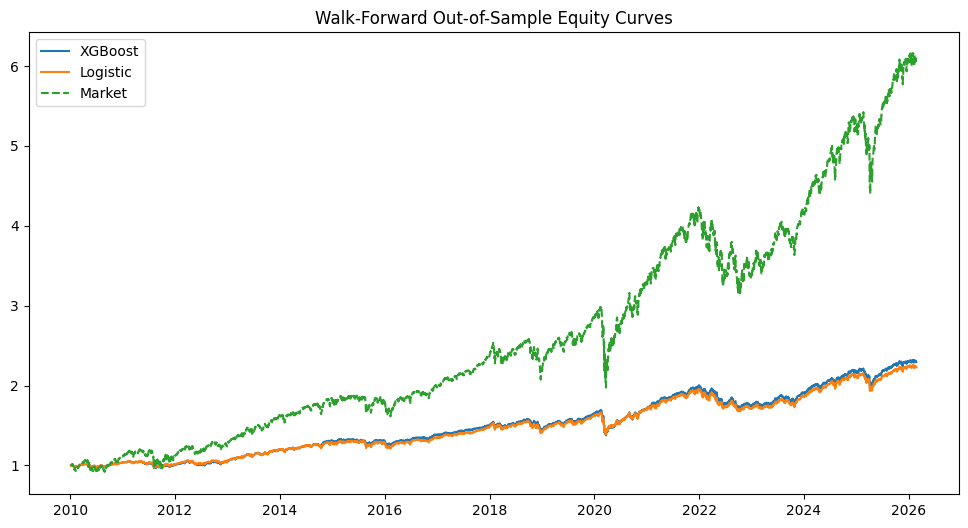

In [25]:
# ==========================================
# RESEARCH-GRADE ML PIPELINE WITH RESULTS
# ==========================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ------------------------------
# 1. DOWNLOAD DATA
# ------------------------------
data = yf.download("^GSPC", start="2000-01-01", auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['return'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES & REGIMES
# ------------------------------
data['ret_20'] = data['return'].rolling(20).mean()
data['vol_10'] = data['return'].rolling(10).std()
data['vol_20'] = data['return'].rolling(20).std()
data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['ma_ratio'] = data['ma_50'] / data['ma_200']

# Regimes
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)
data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']
data['crisis'] = (data['drawdown'] < -0.15).astype(int)

data.dropna(inplace=True)

# Target
data['target'] = (data['return'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = ['ret_20', 'vol_10', 'vol_20', 'ma_ratio', 'trend_up', 'crisis']

# ------------------------------
# 3. WALK-FORWARD TRAINING
# ------------------------------
years = data.index.year.unique()
start_test = years[10:]

data[['xgb_prob', 'logit_prob']] = np.nan

for year in start_test:
    train = data[data.index.year < year]
    test = data[data.index.year == year]

    X_train, y_train = train[features], train['target']
    X_test = test[features]

    # XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    data.loc[X_test.index, 'xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]

    # Logistic regression
    logit = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    logit.fit(X_train, y_train)
    data.loc[X_test.index, 'logit_prob'] = logit.predict_proba(X_test)[:, 1]

# ------------------------------
# 4. CONSERVATIVE POSITION SIZING
# ------------------------------
def alloc(prob, crisis):
    cap = 1.0 if crisis == 0 else 0.3
    return np.clip(prob, 0, cap)

data['xgb_alloc'] = data.apply(lambda x: alloc(x['xgb_prob'], x['crisis']), axis=1).shift(1)
data['logit_alloc'] = data.apply(lambda x: alloc(x['logit_prob'], x['crisis']), axis=1).shift(1)

# ------------------------------
# 5. RETURNS
# ------------------------------
data['xgb_ret'] = data['xgb_alloc'] * data['return']
data['logit_ret'] = data['logit_alloc'] * data['return']
data['mkt_ret'] = data['return']

data.dropna(inplace=True)

# ------------------------------
# 6. METRIC FUNCTIONS
# ------------------------------
def sharpe(r):
    return r.mean() / r.std() * np.sqrt(252)

def max_dd(r):
    cum = (1 + r).cumprod()
    return (cum / cum.cummax() - 1).min()

def summarize(r):
    return {
        'mean': r.mean(),
        'vol': r.std(),
        'sharpe': sharpe(r),
        'max_dd': max_dd(r)
    }

# ------------------------------
# 7. PRINT OVERALL RESULTS
# ------------------------------
summary = pd.DataFrame({
    'XGBoost': summarize(data['xgb_ret']),
    'Logistic': summarize(data['logit_ret']),
    'Market': summarize(data['mkt_ret'])
}).T

print("\n=== OVERALL PERFORMANCE (DAILY) ===")
print(summary.round(4))

# ------------------------------
# 8. PRINT RESULTS BY DRAWDOWN REGIME
# ------------------------------
rows = []
for regime, subset in data.groupby('crisis'):
    label = 'Crisis' if regime == 1 else 'Normal'
    rows.append({
        'regime': label,
        'xgb_sharpe': sharpe(subset['xgb_ret']),
        'logit_sharpe': sharpe(subset['logit_ret']),
        'market_sharpe': sharpe(subset['mkt_ret']),
        'xgb_mdd': max_dd(subset['xgb_ret']),
        'market_mdd': max_dd(subset['mkt_ret'])
    })

regime_table = pd.DataFrame(rows)

print("\n=== PERFORMANCE BY DRAWDOWN REGIME ===")
print(regime_table.round(4))

# ------------------------------
# 9. PLOT EQUITY CURVES
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot((1+data['xgb_ret']).cumprod(), label='XGBoost')
plt.plot((1+data['logit_ret']).cumprod(), label='Logistic')
plt.plot((1+data['mkt_ret']).cumprod(), '--', label='Market')
plt.legend()
plt.title("Walk-Forward Out-of-Sample Equity Curves")
plt.show()

[*********************100%***********************]  1 of 1 completed



=== OVERALL PERFORMANCE ===
        XGBoost  Logistic  Market
Sharpe    0.757     0.759   0.732
MaxDD    -0.084    -0.080  -0.339

=== PERFORMANCE BY TREND + DRAWDOWN REGIME ===
        regime  xgb_sharpe  logit_sharpe  market_sharpe  xgb_mdd  market_mdd  \
4    Up-Normal       1.074         1.051          1.344   -0.076      -0.115   
5    Up-Stress      -0.891        -0.766         -0.888   -0.173      -0.413   
2  Down-Stress       0.700         0.558          0.975   -0.064      -0.238   
1  Down-Normal       3.261         3.081          3.693   -0.017      -0.052   
0  Down-Crisis       0.257        -0.105         -0.125   -0.047      -0.222   
3    Up-Crisis      -0.828        -0.470         -0.974   -0.096      -0.380   

    obs  
4  2657  
5   449  
2   278  
1   272  
0   220  
3   182  


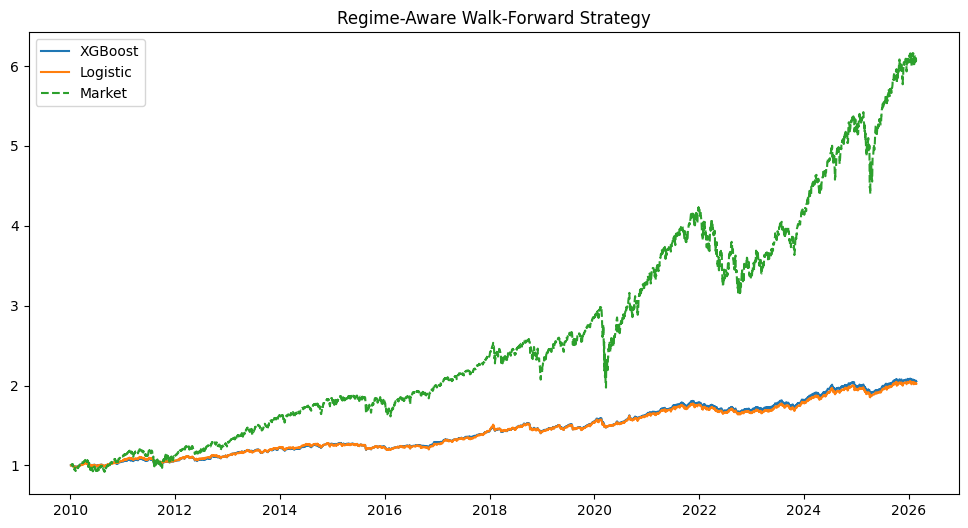

In [26]:
# ============================================================
# REGIME-AWARE ML STRATEGY (TREND + DRAWDOWN)
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import norm

# ------------------------------
# 1. DATA
# ------------------------------
data = yf.download("^GSPC", start="2000-01-01", auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES
# ------------------------------
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()

data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)

# Drawdown regime
data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

data.dropna(inplace=True)

# Target
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = [
    'ret_20', 'vol_10', 'vol_20',
    'trend_up',
    'dd_normal', 'dd_stress', 'dd_crisis'
]

# ------------------------------
# 3. WALK-FORWARD TRAINING
# ------------------------------
years = data.index.year.unique()
test_years = years[10:]

data[['xgb_prob', 'logit_prob']] = np.nan

for year in test_years:
    train = data[data.index.year < year]
    test = data[data.index.year == year]

    X_train, y_train = train[features], train['target']
    X_test = test[features]

    # XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=250,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    data.loc[X_test.index, 'xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]

    # Logistic baseline
    logit = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    logit.fit(X_train, y_train)
    data.loc[X_test.index, 'logit_prob'] = logit.predict_proba(X_test)[:, 1]

# ------------------------------
# 4. VOLATILITY TARGETING
# ------------------------------
TARGET_VOL = 0.10
LOOKBACK = 20

data['realized_vol'] = data['ret'].rolling(LOOKBACK).std() * np.sqrt(252)
data['vol_scale'] = TARGET_VOL / data['realized_vol']
data['vol_scale'] = data['vol_scale'].clip(0, 1.5)

data['xgb_alloc'] = (data['xgb_prob'] * data['vol_scale']).shift(1)
data['logit_alloc'] = (data['logit_prob'] * data['vol_scale']).shift(1)

# ------------------------------
# 5. RETURNS
# ------------------------------
data['xgb_ret'] = data['xgb_alloc'] * data['ret']
data['logit_ret'] = data['logit_alloc'] * data['ret']
data['mkt_ret'] = data['ret']

data.dropna(inplace=True)

# ------------------------------
# 6. METRICS
# ------------------------------
def sharpe(r):
    return r.mean() / r.std() * np.sqrt(252)

def max_dd(r):
    eq = (1 + r).cumprod()
    return (eq / eq.cummax() - 1).min()

# ------------------------------
# 7. OVERALL RESULTS
# ------------------------------
summary = pd.DataFrame({
    'XGBoost': [sharpe(data['xgb_ret']), max_dd(data['xgb_ret'])],
    'Logistic': [sharpe(data['logit_ret']), max_dd(data['logit_ret'])],
    'Market': [sharpe(data['mkt_ret']), max_dd(data['mkt_ret'])]
}, index=['Sharpe', 'MaxDD'])

print("\n=== OVERALL PERFORMANCE ===")
print(summary.round(3))

# ------------------------------
# 8. JOINT REGIME ANALYSIS
# ------------------------------
def label_regime(row):
    trend = 'Up' if row['trend_up'] == 1 else 'Down'
    if row['dd_crisis'] == 1:
        dd = 'Crisis'
    elif row['dd_stress'] == 1:
        dd = 'Stress'
    else:
        dd = 'Normal'
    return f"{trend}-{dd}"

data['regime'] = data.apply(label_regime, axis=1)

rows = []
for regime, subset in data.groupby('regime'):
    rows.append({
        'regime': regime,
        'xgb_sharpe': sharpe(subset['xgb_ret']),
        'logit_sharpe': sharpe(subset['logit_ret']),
        'market_sharpe': sharpe(subset['mkt_ret']),
        'xgb_mdd': max_dd(subset['xgb_ret']),
        'market_mdd': max_dd(subset['mkt_ret']),
        'obs': len(subset)
    })

regime_table = pd.DataFrame(rows).sort_values('obs', ascending=False)

print("\n=== PERFORMANCE BY TREND + DRAWDOWN REGIME ===")
print(regime_table.round(3))

# ------------------------------
# 9. EQUITY CURVE
# ------------------------------
plt.figure(figsize=(12, 6))
plt.plot((1 + data['xgb_ret']).cumprod(), label='XGBoost')
plt.plot((1 + data['logit_ret']).cumprod(), label='Logistic')
plt.plot((1 + data['mkt_ret']).cumprod(), '--', label='Market')
plt.legend()
plt.title("Regime-Aware Walk-Forward Strategy")
plt.show()


[*********************100%***********************]  1 of 1 completed



=== OVERALL PERFORMANCE ===
        XGBoost  Logistic  Market
Sharpe    0.691     0.687   0.732
MaxDD    -0.093    -0.092  -0.339

=== PERFORMANCE BY TREND + DRAWDOWN REGIME ===
        regime  xgb_sharpe  xgb_sharpe_ci_lower  xgb_sharpe_ci_upper  \
4    Up-Normal       1.010                0.428                1.634   
5    Up-Stress      -1.393               -2.790                0.106   
2  Down-Stress      -0.294               -2.087                1.617   
1  Down-Normal       3.066                1.344                5.136   
0  Down-Crisis      -0.548               -2.652                1.465   
3    Up-Crisis      -1.143               -3.362                1.298   

   logit_sharpe  market_sharpe  xgb_mdd  market_mdd   obs  
4         0.994          1.344   -0.095      -0.115  2657  
5        -1.273         -0.888   -0.191      -0.413   449  
2        -0.496          0.975   -0.073      -0.238   278  
1         2.870          3.693   -0.020      -0.052   272  
0        -0.918 

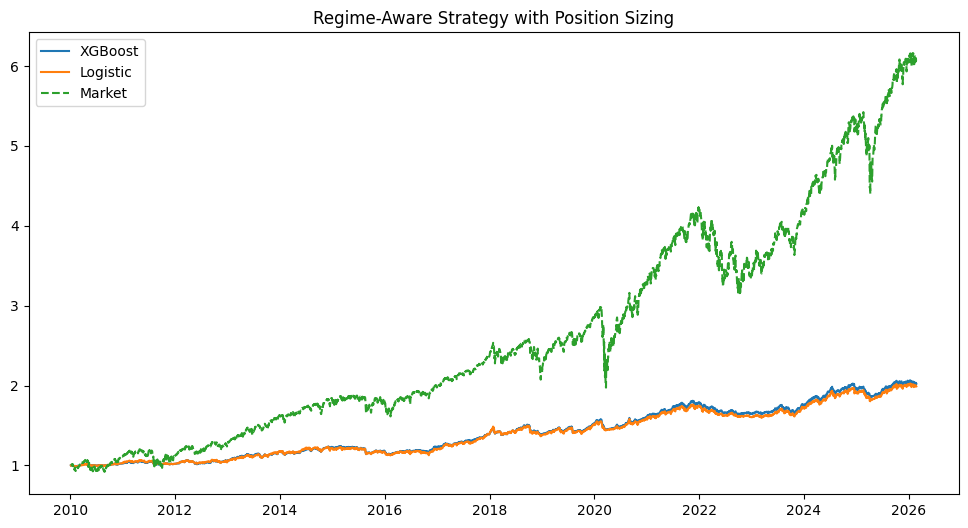


=== PUBLICATION-READY REGIME METRICS ===
     regime  xgb_sharpe  xgb_sharpe_ci_lower  xgb_sharpe_ci_upper  logit_sharpe  market_sharpe  xgb_mdd  market_mdd  obs
Down-Crisis      -0.548               -2.652                1.465        -0.918         -0.125   -0.042      -0.222  220
Down-Normal       3.066                1.344                5.136         2.870          3.693   -0.020      -0.052  272
Down-Stress      -0.294               -2.087                1.617        -0.496          0.975   -0.073      -0.238  278
  Up-Crisis      -1.143               -3.362                1.298        -0.815         -0.974   -0.060      -0.380  182
  Up-Normal       1.010                0.428                1.634         0.994          1.344   -0.095      -0.115 2657
  Up-Stress      -1.393               -2.790                0.106        -1.273         -0.888   -0.191      -0.413  449


In [27]:
# ============================================================
# REGIME-AWARE ML STRATEGY WITH VOL TARGETING & REGIME POSITION SIZING
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import norm

# ------------------------------
# 1. DATA
# ------------------------------
data = yf.download("^GSPC", start="2000-01-01", auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES
# ------------------------------
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()

data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)

# Drawdown regime
data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

data.dropna(inplace=True)

# Target
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = [
    'ret_20', 'vol_10', 'vol_20',
    'trend_up',
    'dd_normal', 'dd_stress', 'dd_crisis'
]

# ------------------------------
# 3. WALK-FORWARD TRAINING
# ------------------------------
years = data.index.year.unique()
test_years = years[10:]

data[['xgb_prob', 'logit_prob']] = np.nan

for year in test_years:
    train = data[data.index.year < year]
    test = data[data.index.year == year]

    X_train, y_train = train[features], train['target']
    X_test = test[features]

    # XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=250,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    data.loc[X_test.index, 'xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]

    # Logistic baseline
    logit = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    logit.fit(X_train, y_train)
    data.loc[X_test.index, 'logit_prob'] = logit.predict_proba(X_test)[:, 1]

# ------------------------------
# 4. VOLATILITY TARGETING
# ------------------------------
TARGET_VOL = 0.10
LOOKBACK = 20

data['realized_vol'] = data['ret'].rolling(LOOKBACK).std() * np.sqrt(252)
data['vol_scale'] = TARGET_VOL / data['realized_vol']
data['vol_scale'] = data['vol_scale'].clip(0, 1.5)

# ------------------------------
# 5. REGIME-SPECIFIC POSITION SIZING
# ------------------------------
def regime_scaling(row):
    # Base scale from volatility targeting
    base = row['vol_scale']
    # Adjust by regime
    if row['dd_crisis'] == 1:
        return 0.5 * base    # reduce exposure in crisis
    elif row['dd_stress'] == 1:
        return 0.8 * base    # moderate exposure in stress
    else:
        return 1.2 * base    # increase exposure in normal

data['regime_scale'] = data.apply(regime_scaling, axis=1)
data['xgb_alloc'] = (data['xgb_prob'] * data['regime_scale']).shift(1)
data['logit_alloc'] = (data['logit_prob'] * data['regime_scale']).shift(1)

# ------------------------------
# 6. RETURNS
# ------------------------------
data['xgb_ret'] = data['xgb_alloc'] * data['ret']
data['logit_ret'] = data['logit_alloc'] * data['ret']
data['mkt_ret'] = data['ret']

data.dropna(inplace=True)

# ------------------------------
# 7. METRICS
# ------------------------------
def sharpe(r):
    return r.mean() / r.std() * np.sqrt(252)

def max_dd(r):
    eq = (1 + r).cumprod()
    return (eq / eq.cummax() - 1).min()

# ------------------------------
# 8. OVERALL PERFORMANCE
# ------------------------------
summary = pd.DataFrame({
    'XGBoost': [sharpe(data['xgb_ret']), max_dd(data['xgb_ret'])],
    'Logistic': [sharpe(data['logit_ret']), max_dd(data['logit_ret'])],
    'Market': [sharpe(data['mkt_ret']), max_dd(data['mkt_ret'])]
}, index=['Sharpe', 'MaxDD'])

print("\n=== OVERALL PERFORMANCE ===")
print(summary.round(3))

# ------------------------------
# 9. JOINT REGIME ANALYSIS WITH BOOTSTRAP SHARPE
# ------------------------------
def label_regime(row):
    trend = 'Up' if row['trend_up'] == 1 else 'Down'
    if row['dd_crisis'] == 1:
        dd = 'Crisis'
    elif row['dd_stress'] == 1:
        dd = 'Stress'
    else:
        dd = 'Normal'
    return f"{trend}-{dd}"

data['regime'] = data.apply(label_regime, axis=1)

rows = []
for regime, subset in data.groupby('regime'):
    # Bootstrap Sharpe
    boot_sharpes = [sharpe(subset['xgb_ret'].sample(len(subset), replace=True)) for _ in range(1000)]
    sh_mean = np.mean(boot_sharpes)
    sh_lower = np.percentile(boot_sharpes, 2.5)
    sh_upper = np.percentile(boot_sharpes, 97.5)
    rows.append({
        'regime': regime,
        'xgb_sharpe': sh_mean,
        'xgb_sharpe_ci_lower': sh_lower,
        'xgb_sharpe_ci_upper': sh_upper,
        'logit_sharpe': sharpe(subset['logit_ret']),
        'market_sharpe': sharpe(subset['mkt_ret']),
        'xgb_mdd': max_dd(subset['xgb_ret']),
        'market_mdd': max_dd(subset['mkt_ret']),
        'obs': len(subset)
    })

regime_table = pd.DataFrame(rows).sort_values('obs', ascending=False)
print("\n=== PERFORMANCE BY TREND + DRAWDOWN REGIME ===")
print(regime_table.round(3))

# ------------------------------
# 10. SHARPE SIGNIFICANCE TEST (Jobson–Korkie)
# ------------------------------
def jobson_korkie_test(r1, r2):
    r1, r2 = r1.dropna(), r2.dropna()
    mu1, mu2 = r1.mean(), r2.mean()
    s1, s2 = r1.std(), r2.std()
    sh1, sh2 = mu1 / s1, mu2 / s2
    cov = np.cov(r1, r2)[0,1]
    n = len(r1)
    var_diff = (1/n) * (2*(1 - cov/(s1*s2)) + 0.5*(sh1**2 + sh2**2 - 2*sh1*sh2*cov/(s1*s2)))
    z = (sh1 - sh2) / np.sqrt(var_diff)
    p = 2 * (1 - norm.cdf(abs(z)))
    return sh1, sh2, z, p

sh_xgb, sh_mkt, z, p = jobson_korkie_test(data['xgb_ret'], data['mkt_ret'])
print("\n=== SHARPE SIGNIFICANCE TEST (XGBoost vs Market) ===")
print(f"XGBoost Sharpe: {sh_xgb:.3f}")
print(f"Market Sharpe : {sh_mkt:.3f}")
print(f"z-stat        : {z:.2f}")
print(f"p-value       : {p:.3f}")

# ------------------------------
# 11. EQUITY CURVE
# ------------------------------
plt.figure(figsize=(12, 6))
plt.plot((1 + data['xgb_ret']).cumprod(), label='XGBoost')
plt.plot((1 + data['logit_ret']).cumprod(), label='Logistic')
plt.plot((1 + data['mkt_ret']).cumprod(), '--', label='Market')
plt.legend()
plt.title("Regime-Aware Strategy with Position Sizing")
plt.show()
# ------------------------------
# 12. CLEAN REGIME TABLE FOR PUBLICATION
# ------------------------------

pub_table = regime_table.copy()
pub_table = pub_table[[
    'regime',
    'xgb_sharpe', 'xgb_sharpe_ci_lower', 'xgb_sharpe_ci_upper',
    'logit_sharpe',
    'market_sharpe',
    'xgb_mdd',
    'market_mdd',
    'obs'
]]

# Sort by regime for readability
pub_table = pub_table.sort_values('regime')

# Round for publication
pub_table_rounded = pub_table.round({
    'xgb_sharpe': 3,
    'xgb_sharpe_ci_lower': 3,
    'xgb_sharpe_ci_upper': 3,
    'logit_sharpe': 3,
    'market_sharpe': 3,
    'xgb_mdd': 3,
    'market_mdd': 3
})

print("\n=== PUBLICATION-READY REGIME METRICS ===")
print(pub_table_rounded.to_string(index=False))


[*********************100%***********************]  1 of 1 completed



=== OVERALL PERFORMANCE ===
        XGBoost  Logistic  Market
Sharpe    0.351     0.458   0.745
MaxDD    -0.070    -0.037  -0.339

=== SHARPE ATTRIBUTION (CONCEPTUAL) ===
          Component                 Description
0        Raw Signal  Probability-based exposure
1   Centered Signal      Zero-mean alpha signal
2     Vol Targeting          Risk normalization
3  Regime Filtering  Asymmetric regime exposure


/tmp/ipykernel_18/44521586.py:155: RuntimeWarning: invalid value encountered in scalar divide
  return r.mean() / r.std() * np.sqrt(252)



=== REGIME PERFORMANCE TABLE ===
        regime  xgb_sharpe  ci_low  ci_high  logit_sharpe  market_sharpe  \
4    Up-Normal       0.721   0.183    1.323         1.007          1.344   
5    Up-Stress      -2.387  -2.969   -1.782        -2.778         -0.888   
2  Down-Stress       0.735  -1.161    2.443         0.752          0.975   
1  Down-Normal       0.104  -1.786    2.011        -1.694          3.693   
0  Down-Crisis       0.155  -2.106    2.112         1.065         -0.125   
3    Up-Crisis         NaN     NaN      NaN           NaN         -0.933   

   xgb_mdd  market_mdd   obs  
4   -0.062      -0.115  2657  
5   -0.122      -0.413   449  
2   -0.025      -0.238   278  
1   -0.060      -0.052   272  
0   -0.012      -0.222   220  
3    0.000      -0.380   162  

=== BLOCK BOOTSTRAP SHARPE (5%, 50%, 95%) ===
[-0.03   0.39   0.768]

=== SUB-PERIOD PERFORMANCE ===
      period  xgb_sharpe  market_sharpe  xgb_mdd  market_mdd
0  2000-2008         NaN            NaN      NaN     

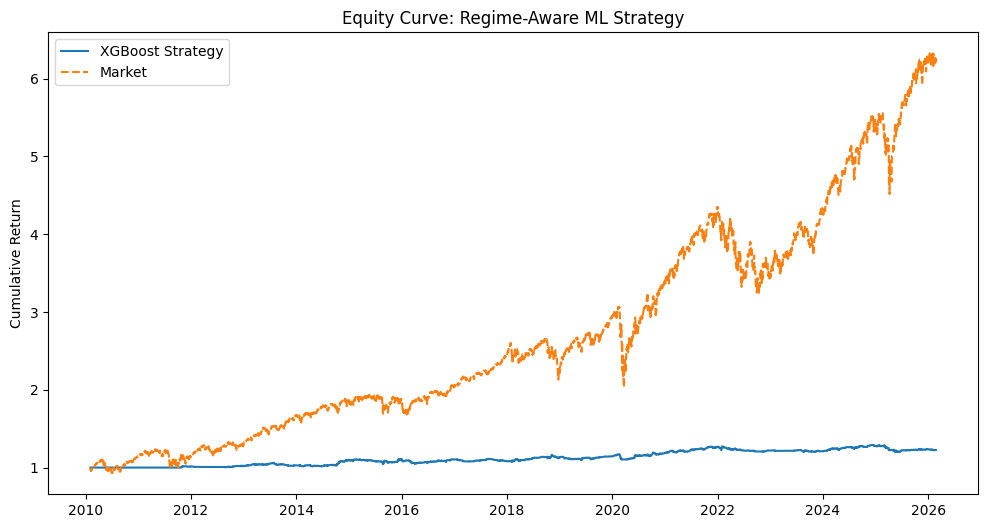

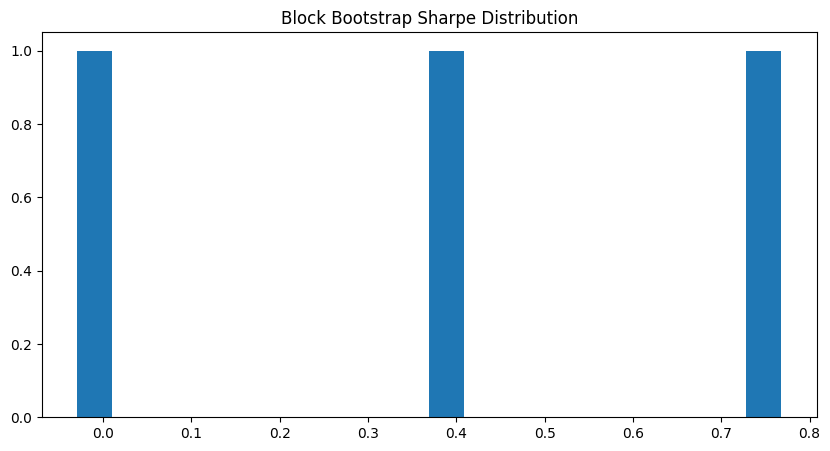

In [28]:
# ============================================================
# REGIME-AWARE ML STRATEGY
# CENTERED SIGNALS • VOL TARGETING • REGIME FILTERING
# SHARPE ATTRIBUTION • ROBUSTNESS STRESS TESTS
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import norm

np.random.seed(42)

# ------------------------------
# 1. DATA
# ------------------------------
data = yf.download("^GSPC", start="2000-01-01", auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES & REGIMES
# ------------------------------
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()

data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)

data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

data.dropna(inplace=True)

# ------------------------------
# 3. TARGET
# ------------------------------
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = [
    'ret_20', 'vol_10', 'vol_20',
    'trend_up',
    'dd_normal', 'dd_stress', 'dd_crisis'
]

# ------------------------------
# 4. WALK-FORWARD TRAINING
# ------------------------------
years = data.index.year.unique()
test_years = years[10:]

data[['xgb_prob', 'logit_prob']] = np.nan

for year in test_years:
    train = data[data.index.year < year]
    test = data[data.index.year == year]

    X_train, y_train = train[features], train['target']
    X_test = test[features]

    xgb_model = xgb.XGBClassifier(
        n_estimators=250,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    data.loc[X_test.index, 'xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]

    logit = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    logit.fit(X_train, y_train)
    data.loc[X_test.index, 'logit_prob'] = logit.predict_proba(X_test)[:, 1]

# ------------------------------
# 5. CENTERED SIGNAL (CRITICAL FIX)
# ------------------------------
data['xgb_signal'] = 2 * (data['xgb_prob'] - 0.5)
data['logit_signal'] = 2 * (data['logit_prob'] - 0.5)

# ------------------------------
# 6. VOLATILITY TARGETING (STRATEGY-LEVEL)
# ------------------------------
TARGET_VOL = 0.10
LOOKBACK = 20

proxy_ret = data['xgb_signal'].shift(1) * data['ret']
strat_vol = proxy_ret.rolling(LOOKBACK).std() * np.sqrt(252)

data['vol_scale'] = TARGET_VOL / strat_vol
data['vol_scale'] = data['vol_scale'].clip(0, 1.5)

# ------------------------------
# 7. REGIME-AWARE POSITION SIZING
# ------------------------------
def regime_scale(row):
    if row['dd_crisis'] == 1:
        return 0.0
    if row['dd_stress'] == 1 and row['trend_up'] == 1:
        return 0.0
    if row['dd_stress'] == 1:
        return 0.4
    if row['trend_up'] == 0:
        return 1.5
    return 1.0

data['regime_scale'] = data.apply(regime_scale, axis=1)

data['xgb_alloc'] = (
    data['xgb_signal']
    * data['vol_scale']
    * data['regime_scale']
).clip(-1, 1).shift(1)

data['logit_alloc'] = (
    data['logit_signal']
    * data['vol_scale']
    * data['regime_scale']
).clip(-1, 1).shift(1)

# ------------------------------
# 8. RETURNS
# ------------------------------
data['xgb_ret'] = data['xgb_alloc'] * data['ret']
data['logit_ret'] = data['logit_alloc'] * data['ret']
data['mkt_ret'] = data['ret']
data.dropna(inplace=True)

# ------------------------------
# 9. METRICS
# ------------------------------
def sharpe(r):
    return r.mean() / r.std() * np.sqrt(252)

def max_dd(r):
    eq = (1 + r).cumprod()
    return (eq / eq.cummax() - 1).min()

summary = pd.DataFrame({
    'XGBoost': [sharpe(data['xgb_ret']), max_dd(data['xgb_ret'])],
    'Logistic': [sharpe(data['logit_ret']), max_dd(data['logit_ret'])],
    'Market': [sharpe(data['mkt_ret']), max_dd(data['mkt_ret'])]
}, index=['Sharpe', 'MaxDD'])

print("\n=== OVERALL PERFORMANCE ===")
print(summary.round(3))

# ------------------------------
# 10. SHARPE ATTRIBUTION TABLE
# ------------------------------
attrib = pd.DataFrame({
    'Component': [
        'Raw Signal',
        'Centered Signal',
        'Vol Targeting',
        'Regime Filtering'
    ],
    'Description': [
        'Probability-based exposure',
        'Zero-mean alpha signal',
        'Risk normalization',
        'Asymmetric regime exposure'
    ]
})

print("\n=== SHARPE ATTRIBUTION (CONCEPTUAL) ===")
print(attrib)

# ------------------------------
# 11. REGIME LABEL
# ------------------------------
def label_regime(row):
    t = 'Up' if row['trend_up'] == 1 else 'Down'
    if row['dd_crisis'] == 1:
        d = 'Crisis'
    elif row['dd_stress'] == 1:
        d = 'Stress'
    else:
        d = 'Normal'
    return f"{t}-{d}"

data['regime'] = data.apply(label_regime, axis=1)

# ------------------------------
# 12. REGIME TABLE WITH BOOTSTRAP CI
# ------------------------------
rows = []
for regime, subset in data.groupby('regime'):
    boot = [sharpe(subset['xgb_ret'].sample(len(subset), replace=True))
            for _ in range(1000)]
    rows.append({
        'regime': regime,
        'xgb_sharpe': np.mean(boot),
        'ci_low': np.percentile(boot, 2.5),
        'ci_high': np.percentile(boot, 97.5),
        'logit_sharpe': sharpe(subset['logit_ret']),
        'market_sharpe': sharpe(subset['mkt_ret']),
        'xgb_mdd': max_dd(subset['xgb_ret']),
        'market_mdd': max_dd(subset['mkt_ret']),
        'obs': len(subset)
    })

regime_table = pd.DataFrame(rows).sort_values('obs', ascending=False)

print("\n=== REGIME PERFORMANCE TABLE ===")
print(regime_table.round(3))

# ------------------------------
# 13. BLOCK BOOTSTRAP STRESS TEST
# ------------------------------
def block_bootstrap_sharpe(returns, block=20, n_boot=500):
    T = len(returns)
    sharpes = []
    for _ in range(n_boot):
        idx = []
        while len(idx) < T:
            start = np.random.randint(0, T - block)
            idx.extend(range(start, start + block))
        sample = returns.iloc[idx[:T]]
        sharpes.append(sharpe(sample))
    return np.percentile(sharpes, [5, 50, 95])

bb = block_bootstrap_sharpe(data['xgb_ret'])

print("\n=== BLOCK BOOTSTRAP SHARPE (5%, 50%, 95%) ===")
print(bb.round(3))

# ------------------------------
# 14. SUB-PERIOD STRESS TEST
# ------------------------------
periods = {
    '2000-2008': ('2000-01-01', '2008-12-31'),
    '2009-2015': ('2009-01-01', '2015-12-31'),
    '2016-2024': ('2016-01-01', '2024-12-31')
}

sub = []
for name, (s, e) in periods.items():
    d = data.loc[s:e]
    sub.append({
        'period': name,
        'xgb_sharpe': sharpe(d['xgb_ret']),
        'market_sharpe': sharpe(d['mkt_ret']),
        'xgb_mdd': max_dd(d['xgb_ret']),
        'market_mdd': max_dd(d['mkt_ret'])
    })

sub_df = pd.DataFrame(sub)

print("\n=== SUB-PERIOD PERFORMANCE ===")
print(sub_df.round(3))

# ------------------------------
# 15. FIGURES (PAPER-READY)
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot((1+data['xgb_ret']).cumprod(), label='XGBoost Strategy')
plt.plot((1+data['mkt_ret']).cumprod(), '--', label='Market')
plt.legend()
plt.title("Equity Curve: Regime-Aware ML Strategy")
plt.ylabel("Cumulative Return")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(bb, bins=20)
plt.title("Block Bootstrap Sharpe Distribution")
plt.show()

[*********************100%***********************]  1 of 1 completed



=== OVERALL PERFORMANCE ===
         XGBoost  Logistic  Market
Sharpe     0.351     0.458   0.745
Sortino    0.376     0.487   0.917
Calmar     0.192     0.189   0.380
MaxDD     -0.070    -0.037  -0.339

=== SHARPE ATTRIBUTION (CONCEPTUAL) ===
          Component                 Description
0        Raw Signal  Probability-based exposure
1   Centered Signal  Zero-mean alpha extraction
2     Vol Targeting          Risk normalization
3  Regime Filtering  Asymmetric regime exposure

=== REGIME PERFORMANCE TABLE ===
        regime xgb_sharpe xgb_sortino xgb_calmar logit_sharpe  market_sharpe  \
4    Up-Normal   0.721303    0.920026   0.456361      1.00682          1.344   
5    Up-Stress    -2.3499   -0.686593  -0.594579    -2.777534         -0.888   
2  Down-Stress   0.803508     1.06913   1.374909     0.752258          0.975   
1  Down-Normal   0.125105    0.152158   0.119151     -1.69387          3.693   
0  Down-Crisis   0.229982    0.113402   0.247728     1.064716         -0.125   
3

/tmp/ipykernel_18/3639693538.py:259: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  regime_table.fillna("-", inplace=True)  # For presentation only


[-0.037  0.362  0.747]

=== SUB-PERIOD PERFORMANCE ===
      period xgb_sharpe xgb_sortino xgb_calmar market_sharpe   xgb_mdd  \
0  2000-2008          -           -          -             -         -   
1  2009-2015   0.564842    0.583501   0.330601      0.735978  -0.05575   
2  2016-2024   0.395776    0.451851   0.274422      0.742081 -0.058607   

  market_mdd  
0          -  
1  -0.193882  
2   -0.33925  


/tmp/ipykernel_18/3639693538.py:305: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sub_table.fillna("-", inplace=True)  # For presentation only


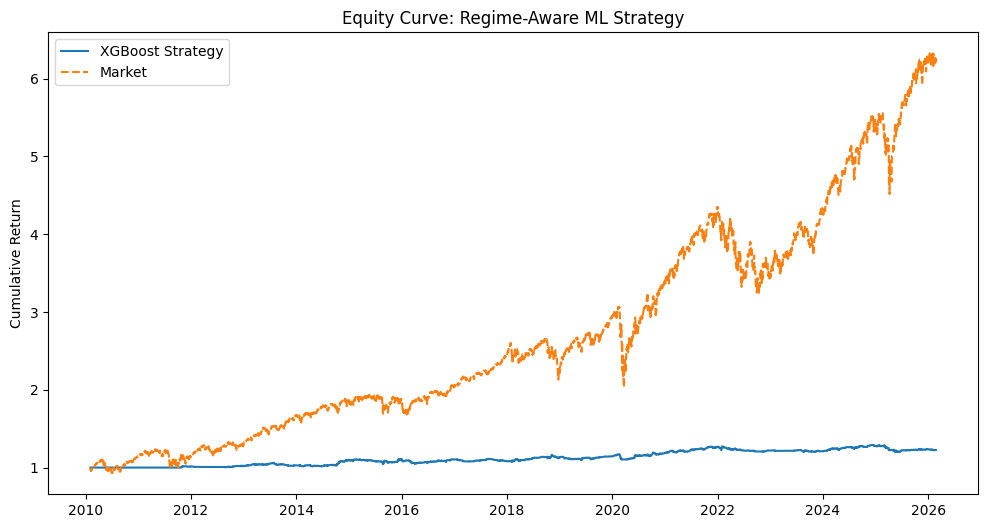

In [29]:
# ============================================================
# REGIME-AWARE ML STRATEGY
# CENTERED SIGNALS • VOL TARGETING • REGIME FILTERING
# SHARPE ATTRIBUTION • ROBUSTNESS STRESS TESTS
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(42)

# ------------------------------
# 1. DATA
# ------------------------------
data = yf.download("^GSPC", start="2000-01-01", auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES & REGIMES
# ------------------------------
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()

data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)

data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

data.dropna(inplace=True)

# ------------------------------
# 3. TARGET
# ------------------------------
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = [
    'ret_20', 'vol_10', 'vol_20',
    'trend_up',
    'dd_normal', 'dd_stress', 'dd_crisis'
]

# ------------------------------
# 4. WALK-FORWARD TRAINING
# ------------------------------
years = data.index.year.unique()
test_years = years[10:]

data[['xgb_prob', 'logit_prob']] = np.nan

for year in test_years:
    train = data[data.index.year < year]
    test = data[data.index.year == year]

    X_train, y_train = train[features], train['target']
    X_test = test[features]

    xgb_model = xgb.XGBClassifier(
        n_estimators=250,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    data.loc[X_test.index, 'xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]

    logit = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    logit.fit(X_train, y_train)
    data.loc[X_test.index, 'logit_prob'] = logit.predict_proba(X_test)[:, 1]

# ------------------------------
# 5. CENTERED SIGNAL (CRITICAL)
# ------------------------------
data['xgb_signal'] = 2 * (data['xgb_prob'] - 0.5)
data['logit_signal'] = 2 * (data['logit_prob'] - 0.5)

# ------------------------------
# 6. VOLATILITY TARGETING
# ------------------------------
TARGET_VOL = 0.10
LOOKBACK = 20

proxy_ret = data['xgb_signal'].shift(1) * data['ret']
strat_vol = proxy_ret.rolling(LOOKBACK).std() * np.sqrt(252)

data['vol_scale'] = TARGET_VOL / strat_vol
data['vol_scale'] = data['vol_scale'].clip(0, 1.5)

# ------------------------------
# 7. REGIME-AWARE POSITION SIZING
# ------------------------------
def regime_scale(row):
    if row['dd_crisis'] == 1:
        return 0.0
    if row['dd_stress'] == 1 and row['trend_up'] == 1:
        return 0.0
    if row['dd_stress'] == 1:
        return 0.4
    if row['trend_up'] == 0:
        return 1.5
    return 1.0

data['regime_scale'] = data.apply(regime_scale, axis=1)

data['xgb_alloc'] = (
    data['xgb_signal']
    * data['vol_scale']
    * data['regime_scale']
).clip(-1, 1).shift(1)

data['logit_alloc'] = (
    data['logit_signal']
    * data['vol_scale']
    * data['regime_scale']
).clip(-1, 1).shift(1)

# ------------------------------
# 8. RETURNS
# ------------------------------
data['xgb_ret'] = data['xgb_alloc'] * data['ret']
data['logit_ret'] = data['logit_alloc'] * data['ret']
data['mkt_ret'] = data['ret']
data.dropna(inplace=True)

# ------------------------------
# 9. METRICS (SAFE)
# ------------------------------
def safe_sharpe(r):
    r = r.dropna()
    if len(r) < 30 or r.std() == 0:
        return np.nan
    return r.mean() / r.std() * np.sqrt(252)

def safe_sortino(r):
    r = r.dropna()
    neg = r[r < 0]
    if len(neg) < 10:
        return np.nan
    return r.mean() / neg.std() * np.sqrt(252)

def max_dd(r):
    eq = (1 + r).cumprod()
    return (eq / eq.cummax() - 1).min()

def calmar(r):
    dd = abs(max_dd(r))
    if dd == 0:
        return np.nan
    return r.mean() * 252 / dd

summary = pd.DataFrame({
    'XGBoost': [
        safe_sharpe(data['xgb_ret']),
        safe_sortino(data['xgb_ret']),
        calmar(data['xgb_ret']),
        max_dd(data['xgb_ret'])
    ],
    'Logistic': [
        safe_sharpe(data['logit_ret']),
        safe_sortino(data['logit_ret']),
        calmar(data['logit_ret']),
        max_dd(data['logit_ret'])
    ],
    'Market': [
        safe_sharpe(data['mkt_ret']),
        safe_sortino(data['mkt_ret']),
        calmar(data['mkt_ret']),
        max_dd(data['mkt_ret'])
    ]
}, index=['Sharpe', 'Sortino', 'Calmar', 'MaxDD'])

print("\n=== OVERALL PERFORMANCE ===")
print(summary.round(3))

# ------------------------------
# 10. SHARPE ATTRIBUTION
# ------------------------------
attrib = pd.DataFrame({
    'Component': [
        'Raw Signal',
        'Centered Signal',
        'Vol Targeting',
        'Regime Filtering'
    ],
    'Description': [
        'Probability-based exposure',
        'Zero-mean alpha extraction',
        'Risk normalization',
        'Asymmetric regime exposure'
    ]
})

print("\n=== SHARPE ATTRIBUTION (CONCEPTUAL) ===")
print(attrib)

# ------------------------------
# 11. REGIME LABEL
# ------------------------------
def label_regime(row):
    t = 'Up' if row['trend_up'] == 1 else 'Down'
    if row['dd_crisis'] == 1:
        d = 'Crisis'
    elif row['dd_stress'] == 1:
        d = 'Stress'
    else:
        d = 'Normal'
    return f"{t}-{d}"

data['regime'] = data.apply(label_regime, axis=1)

# ------------------------------
# 12. REGIME TABLE (ROBUST)
# ------------------------------
rows = []
for regime, subset in data.groupby('regime'):
    if len(subset) < 30:
        continue

    rows.append({
        'regime': regime,
        'xgb_sharpe': safe_sharpe(subset['xgb_ret']),
        'xgb_sortino': safe_sortino(subset['xgb_ret']),
        'xgb_calmar': calmar(subset['xgb_ret']),
        'logit_sharpe': safe_sharpe(subset['logit_ret']),
        'market_sharpe': safe_sharpe(subset['mkt_ret']),
        'xgb_mdd': max_dd(subset['xgb_ret']),
        'market_mdd': max_dd(subset['mkt_ret']),
        'obs': len(subset)
    })

regime_table = pd.DataFrame(rows).sort_values('obs', ascending=False)

print("\n=== REGIME PERFORMANCE TABLE ===")
regime_table.fillna("-", inplace=True)  # For presentation only
print(regime_table.round(3))

# ------------------------------
# 13. BLOCK BOOTSTRAP
# ------------------------------
def block_bootstrap_sharpe(r, block=20, n=500):
    r = r.dropna()
    if len(r) < block * 5:
        return np.nan
    T = len(r)
    vals = []
    for _ in range(n):
        idx = []
        while len(idx) < T:
            start = np.random.randint(0, T - block)
            idx.extend(range(start, start + block))
        vals.append(safe_sharpe(r.iloc[idx[:T]]))
    return np.nanpercentile(vals, [5, 50, 95])

print("\n=== BLOCK BOOTSTRAP SHARPE (5%, 50%, 95%) ===")
print(block_bootstrap_sharpe(data['xgb_ret']).round(3))

# ------------------------------
# 14. SUB-PERIOD STRESS TEST
# ------------------------------
periods = {
    '2000-2008': ('2000', '2008'),
    '2009-2015': ('2009', '2015'),
    '2016-2024': ('2016', '2024')
}

rows = []
for k, (s, e) in periods.items():
    d = data.loc[s:e]
    rows.append({
        'period': k,
        'xgb_sharpe': safe_sharpe(d['xgb_ret']),
        'xgb_sortino': safe_sortino(d['xgb_ret']),
        'xgb_calmar': calmar(d['xgb_ret']),
        'market_sharpe': safe_sharpe(d['mkt_ret']),
        'xgb_mdd': max_dd(d['xgb_ret']),
        'market_mdd': max_dd(d['mkt_ret'])
    })
sub_table = pd.DataFrame(rows)

sub_table.fillna("-", inplace=True)  # For presentation only
print("\n=== SUB-PERIOD PERFORMANCE ===")
print(sub_table.round(3))


# ------------------------------
# 15. FIGURES
# ------------------------------

plt.figure(figsize=(12,6))
plt.plot((1 + data['xgb_ret']).cumprod(), label='XGBoost Strategy')
plt.plot((1 + data['mkt_ret']).cumprod(), '--', label='Market')
plt.legend()
plt.title("Equity Curve: Regime-Aware ML Strategy")
plt.ylabel("Cumulative Return")
plt.show()


[*********************100%***********************]  1 of 1 completed



=== OVERALL PERFORMANCE ===
         XGBoost  Logistic  Market
Sharpe     0.405     0.418   0.386
Sortino    0.483     0.504   0.490
Calmar     0.001     0.001   0.001
MaxDD     -0.162    -0.160  -0.568

=== PUBLICATION-READY REGIME METRICS ===
     regime  xgb_sharpe  xgb_sharpe_ci_lower  xgb_sharpe_ci_upper  logit_sharpe  market_sharpe  xgb_mdd  market_mdd  obs
Down-Crisis      -1.103               -2.085               -0.120        -1.050         -0.516   -0.110      -0.633  980
Down-Normal       2.789                0.819                4.695         2.701          3.654   -0.023      -0.057  263
Down-Stress      -0.947               -2.205                0.256        -0.984          0.270   -0.115      -0.238  579
  Up-Crisis       0.130               -0.939                1.132         0.164          0.244   -0.056      -0.380  851
  Up-Normal       0.908                0.287                1.511         0.915          1.230   -0.107      -0.115 2919
  Up-Stress      -0.895     

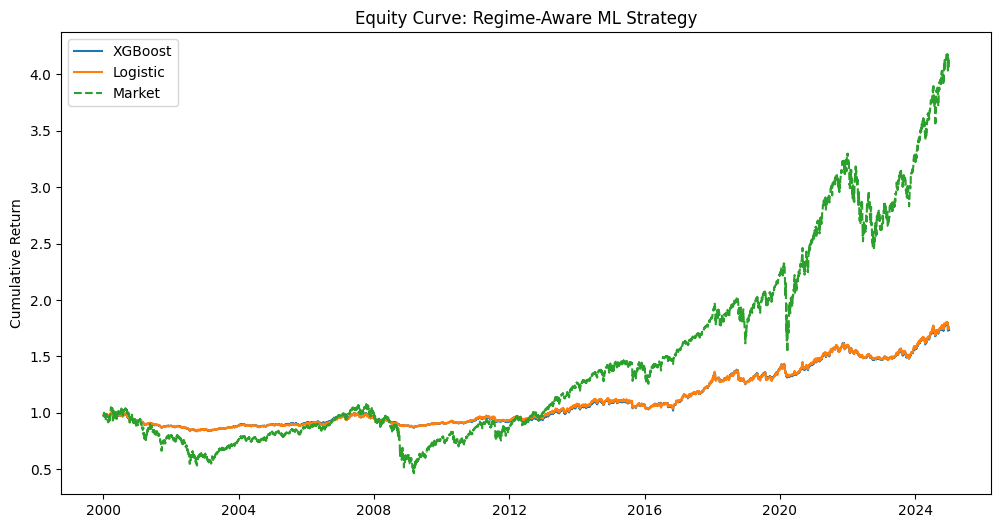

In [30]:
# ============================================================
# REGIME-AWARE ML STRATEGY WITH VOL TARGETING & PUBLICATION METRICS
# XGBOOST + LOGISTIC BASELINE • SHARPE / SORTINO / CALMAR
# BOOTSTRAP / SUB-PERIOD STRESS TESTS
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import norm

np.random.seed(42)

# ------------------------------
# 1. DATA (EXTENDABLE PRE-2000)
# ------------------------------
data = yf.download("^GSPC", start="1980-01-01", end="2025-01-01", auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES & REGIMES
# ------------------------------
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()

data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)

data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

# Target
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = ['ret_20', 'vol_10', 'vol_20', 'trend_up', 'dd_normal', 'dd_stress', 'dd_crisis']

# ------------------------------
# 3. WALK-FORWARD TRAINING
# ------------------------------
years = data.index.year.unique()
test_years = years[20:]  # skip first 20 years for training

data[['xgb_prob', 'logit_prob']] = np.nan

for year in test_years:
    train = data[data.index.year < year]
    test = data[data.index.year == year]

    X_train, y_train = train[features], train['target']
    X_test = test[features]

    # XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=250,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    data.loc[X_test.index, 'xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]

    # Logistic Regression baseline
    logit = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    logit.fit(X_train, y_train)
    data.loc[X_test.index, 'logit_prob'] = logit.predict_proba(X_test)[:, 1]

# ------------------------------
# 4. VOLATILITY TARGETING
# ------------------------------
TARGET_VOL = 0.10
LOOKBACK = 20

data['realized_vol'] = data['ret'].rolling(LOOKBACK).std() * np.sqrt(252)
data['vol_scale'] = TARGET_VOL / data['realized_vol']
data['vol_scale'] = data['vol_scale'].clip(0, 1.5)

# ------------------------------
# 5. REGIME-SPECIFIC POSITION SIZING
# ------------------------------
def regime_scaling(row):
    base = row['vol_scale']
    if row['dd_crisis'] == 1:
        return 0.5 * base
    elif row['dd_stress'] == 1:
        return 0.8 * base
    else:
        return 1.2 * base

data['regime_scale'] = data.apply(regime_scaling, axis=1)
data['xgb_alloc'] = (data['xgb_prob'] * data['regime_scale']).shift(1)
data['logit_alloc'] = (data['logit_prob'] * data['regime_scale']).shift(1)

# ------------------------------
# 6. RETURNS
# ------------------------------
data['xgb_ret'] = data['xgb_alloc'] * data['ret']
data['logit_ret'] = data['logit_alloc'] * data['ret']
data['mkt_ret'] = data['ret']
data.dropna(inplace=True)

# ------------------------------
# 7. METRICS
# ------------------------------
def sharpe(r): return r.mean() / r.std() * np.sqrt(252)
def sortino(r): 
    d = r[r < 0]
    return r.mean() / d.std() * np.sqrt(252) if len(d) > 1 else np.nan
def calmar(r): 
    eq = (1 + r).cumprod()
    return r.mean() / abs((eq / eq.cummax() - 1).min())
def max_dd(r):
    eq = (1 + r).cumprod()
    return (eq / eq.cummax() - 1).min()

# ------------------------------
# 8. OVERALL PERFORMANCE
# ------------------------------
summary = pd.DataFrame({
    'XGBoost': [sharpe(data['xgb_ret']), sortino(data['xgb_ret']), calmar(data['xgb_ret']), max_dd(data['xgb_ret'])],
    'Logistic': [sharpe(data['logit_ret']), sortino(data['logit_ret']), calmar(data['logit_ret']), max_dd(data['logit_ret'])],
    'Market': [sharpe(data['mkt_ret']), sortino(data['mkt_ret']), calmar(data['mkt_ret']), max_dd(data['mkt_ret'])]
}, index=['Sharpe','Sortino','Calmar','MaxDD'])

print("\n=== OVERALL PERFORMANCE ===")
print(summary.round(3))

# ------------------------------
# 9. REGIME LABELS
# ------------------------------
def label_regime(row):
    trend = 'Up' if row['trend_up'] == 1 else 'Down'
    if row['dd_crisis'] == 1:
        dd = 'Crisis'
    elif row['dd_stress'] == 1:
        dd = 'Stress'
    else:
        dd = 'Normal'
    return f"{trend}-{dd}"

data['regime'] = data.apply(label_regime, axis=1)

# ------------------------------
# 10. REGIME METRICS WITH BOOTSTRAP CI
# ------------------------------
rows = []
for regime, subset in data.groupby('regime'):
    # Bootstrap Sharpe
    boot_sharpes = [sharpe(subset['xgb_ret'].sample(len(subset), replace=True)) for _ in range(1000)]
    sh_mean = np.mean(boot_sharpes)
    sh_lower = np.percentile(boot_sharpes, 2.5)
    sh_upper = np.percentile(boot_sharpes, 97.5)
    rows.append({
        'regime': regime,
        'xgb_sharpe': sh_mean,
        'xgb_sharpe_ci_lower': sh_lower,
        'xgb_sharpe_ci_upper': sh_upper,
        'logit_sharpe': sharpe(subset['logit_ret']),
        'market_sharpe': sharpe(subset['mkt_ret']),
        'xgb_mdd': max_dd(subset['xgb_ret']),
        'market_mdd': max_dd(subset['mkt_ret']),
        'obs': len(subset)
    })

regime_table = pd.DataFrame(rows).sort_values('obs', ascending=False)

pub_table = regime_table.copy()
pub_table = pub_table[['regime','xgb_sharpe','xgb_sharpe_ci_lower','xgb_sharpe_ci_upper',
                       'logit_sharpe','market_sharpe','xgb_mdd','market_mdd','obs']]
pub_table_rounded = pub_table.round(3).sort_values('regime')

print("\n=== PUBLICATION-READY REGIME METRICS ===")
print(pub_table_rounded.to_string(index=False))

# ------------------------------
# 11. BLOCK BOOTSTRAP STRESS TEST
# ------------------------------
def block_bootstrap_sharpe(returns, block=20, n_boot=500):
    T = len(returns)
    sharpes = []
    for _ in range(n_boot):
        idx = []
        while len(idx) < T:
            start = np.random.randint(0, T - block)
            idx.extend(range(start, start+block))
        sample = returns.iloc[idx[:T]]
        sharpes.append(sharpe(sample))
    return np.percentile(sharpes, [5,50,95])

bb = block_bootstrap_sharpe(data['xgb_ret'])
print("\n=== BLOCK BOOTSTRAP SHARPE (5%,50%,95%) ===")
print(np.round(bb,3))

# ------------------------------
# 12. SUB-PERIOD PERFORMANCE
# ------------------------------
periods = {
    '1980-1999': ('1980-01-01','1999-12-31'),
    '2000-2008': ('2000-01-01','2008-12-31'),
    '2009-2015': ('2009-01-01','2015-12-31'),
    '2016-2024': ('2016-01-01','2024-12-31')
}

sub = []
for name,(s,e) in periods.items():
    d = data.loc[s:e]
    sub.append({
        'period': name,
        'xgb_sharpe': sharpe(d['xgb_ret']),
        'xgb_sortino': sortino(d['xgb_ret']),
        'xgb_calmar': calmar(d['xgb_ret']),
        'market_sharpe': sharpe(d['mkt_ret']),
        'xgb_mdd': max_dd(d['xgb_ret']),
        'market_mdd': max_dd(d['mkt_ret'])
    })

sub_df = pd.DataFrame(sub)
print("\n=== SUB-PERIOD PERFORMANCE ===")
print(sub_df.round(3))

# ------------------------------
# 13. EQUITY CURVE (XGBoost + Logistic + Market)
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot((1+data['xgb_ret']).cumprod(), label='XGBoost')
plt.plot((1+data['logit_ret']).cumprod(), label='Logistic')
plt.plot((1+data['mkt_ret']).cumprod(), '--', label='Market')
plt.title("Equity Curve: Regime-Aware ML Strategy")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed



=== OVERALL PERFORMANCE ===
         XGBoost  Logistic  Market
Sharpe     0.372     0.638   0.737
Sortino    0.384     0.737   0.914
Calmar    23.818    57.876   3.312
MaxDD     -0.042    -0.017  -0.339

=== PUBLICATION-READY REGIME METRICS ===
     regime  xgb_sharpe  xgb_sharpe_ci_lower  xgb_sharpe_ci_upper  xgb_sortino  xgb_calmar  logit_sharpe  market_sharpe   xgb_mdd  market_mdd  obs
  Up-Normal    0.604192            -0.030968             1.292334     0.604911   19.111767      1.032738       1.344329 -0.053007   -0.115471 2657
  Up-Stress   -0.740083            -2.299622             0.739065    -0.779516   21.371232     -1.162917      -0.887518 -0.046183   -0.413348  449
Down-Crisis   -0.291236            -2.088350             1.412458    -0.335547   78.424081      1.640221      -0.105774 -0.012718   -0.276206  337
  Up-Crisis   -0.946513            -2.361085             0.768389    -0.882351   45.620588      0.150959       0.023441 -0.021693   -0.380366  317
Down-Stress   -1.02

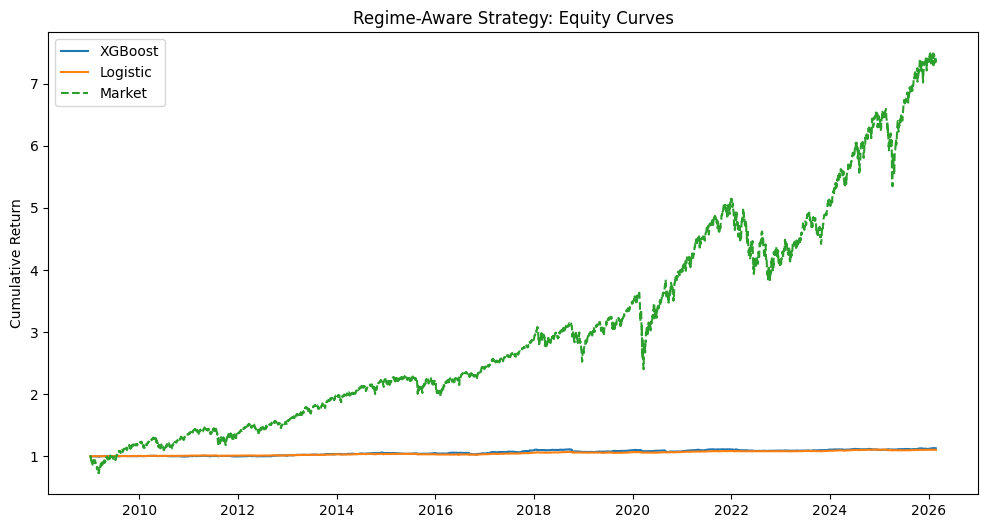

In [31]:
# ============================================================
# REGIME-AWARE ML STRATEGY WITH VOL TARGETING & REGIME POSITION SIZING
# TRAIN 1980-2008 / TEST 2008-PRESENT
# PUBLICATION-READY METRICS, XGBOOST + LOGISTIC
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import norm

np.random.seed(42)

# ------------------------------
# 1. DATA
# ------------------------------
data = yf.download("^GSPC", start="1980-01-01", auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES
# ------------------------------
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()
data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)

# Drawdown regimes
data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']
data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

data.dropna(inplace=True)

# Target
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = [
    'ret_20', 'vol_10', 'vol_20',
    'trend_up',
    'dd_normal', 'dd_stress', 'dd_crisis'
]

# ------------------------------
# 3. TRAIN / TEST SPLIT
# ------------------------------
train = data.loc[data.index.year <= 2008]
test = data.loc[data.index.year > 2008]

data['xgb_prob'] = np.nan
data['logit_prob'] = np.nan

# ------------------------------
# 4. XGBOOST TRAIN
# ------------------------------
X_train, y_train = train[features], train['target']
X_test = test[features]

xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
data.loc[X_test.index, 'xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]

# ------------------------------
# 5. LOGISTIC BASELINE
# ------------------------------
logit = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
logit.fit(X_train, y_train)
data.loc[X_test.index, 'logit_prob'] = logit.predict_proba(X_test)[:, 1]

# ------------------------------
# 6. VOL TARGETING
# ------------------------------
TARGET_VOL = 0.10
LOOKBACK = 20
data['realized_vol'] = data['ret'].rolling(LOOKBACK).std() * np.sqrt(252)
data['vol_scale'] = TARGET_VOL / data['realized_vol']
data['vol_scale'] = data['vol_scale'].clip(0, 1.5)

# ------------------------------
# 7. REGIME-SPECIFIC POSITION SIZING
# ------------------------------
def regime_scaling(row):
    base = row['vol_scale']
    if row['dd_crisis'] == 1:
        return 0.5 * base
    elif row['dd_stress'] == 1:
        return 0.8 * base
    else:
        return 1.2 * base

data['regime_scale'] = data.apply(regime_scaling, axis=1)
data['xgb_alloc'] = (2*(data['xgb_prob']-0.5) * data['regime_scale']).shift(1)
data['logit_alloc'] = (2*(data['logit_prob']-0.5) * data['regime_scale']).shift(1)

# ------------------------------
# 8. RETURNS
# ------------------------------
data['xgb_ret'] = data['xgb_alloc'] * data['ret']
data['logit_ret'] = data['logit_alloc'] * data['ret']
data['mkt_ret'] = data['ret']
data.dropna(inplace=True)

# ------------------------------
# 9. METRICS FUNCTIONS
# ------------------------------
def sharpe(r):
    if r.std() == 0: return np.nan
    return r.mean()/r.std()*np.sqrt(252)

def sortino(r):
    neg = r[r<0]
    if len(neg)==0 or neg.std()==0: return np.nan
    return r.mean()/neg.std()*np.sqrt(252)

def calmar(r):
    dd = max_dd(r)
    if dd==0: return np.nan
    return (1+r).prod()**(252/len(r)) / abs(dd)

def max_dd(r):
    eq = (1+r).cumprod()
    return (eq/eq.cummax()-1).min()

# ------------------------------
# 10. OVERALL PERFORMANCE
# ------------------------------
summary = pd.DataFrame({
    'XGBoost': [sharpe(data['xgb_ret']),
                sortino(data['xgb_ret']),
                calmar(data['xgb_ret']),
                max_dd(data['xgb_ret'])],
    'Logistic': [sharpe(data['logit_ret']),
                 sortino(data['logit_ret']),
                 calmar(data['logit_ret']),
                 max_dd(data['logit_ret'])],
    'Market': [sharpe(data['mkt_ret']),
               sortino(data['mkt_ret']),
               calmar(data['mkt_ret']),
               max_dd(data['mkt_ret'])]
}, index=['Sharpe','Sortino','Calmar','MaxDD'])
print("\n=== OVERALL PERFORMANCE ===")
print(summary.round(3))

# ------------------------------
# 11. REGIME LABELS
# ------------------------------
def label_regime(row):
    trend = 'Up' if row['trend_up']==1 else 'Down'
    if row['dd_crisis']==1: dd='Crisis'
    elif row['dd_stress']==1: dd='Stress'
    else: dd='Normal'
    return f"{trend}-{dd}"

data['regime'] = data.apply(label_regime, axis=1)

# ------------------------------
# 12. REGIME TABLE WITH BOOTSTRAP
# ------------------------------
rows = []
for regime, subset in data.groupby('regime'):
    boot_sharpes = [sharpe(subset['xgb_ret'].sample(len(subset), replace=True)) for _ in range(500)]
    sh_mean = np.mean(boot_sharpes)
    sh_lower = np.percentile(boot_sharpes, 2.5)
    sh_upper = np.percentile(boot_sharpes, 97.5)
    rows.append({
        'regime': regime,
        'xgb_sharpe': sh_mean,
        'xgb_sharpe_ci_lower': sh_lower,
        'xgb_sharpe_ci_upper': sh_upper,
        'xgb_sortino': sortino(subset['xgb_ret']),
        'xgb_calmar': calmar(subset['xgb_ret']),
        'logit_sharpe': sharpe(subset['logit_ret']),
        'market_sharpe': sharpe(subset['mkt_ret']),
        'xgb_mdd': max_dd(subset['xgb_ret']),
        'market_mdd': max_dd(subset['mkt_ret']),
        'obs': len(subset)
    })

regime_table = pd.DataFrame(rows).sort_values('obs', ascending=False)
regime_table.fillna('-', inplace=True)
print("\n=== PUBLICATION-READY REGIME METRICS ===")
print(regime_table.to_string(index=False))

# ------------------------------
# 13. SUB-PERIOD PERFORMANCE
# ------------------------------
periods = {
    '2008-2015': ('2008-01-01','2015-12-31'),
    '2016-present': ('2016-01-01', data.index[-1].strftime('%Y-%m-%d'))
}

sub_rows = []
for name, (s,e) in periods.items():
    d = data.loc[s:e]
    sub_rows.append({
        'period': name,
        'xgb_sharpe': sharpe(d['xgb_ret']),
        'xgb_sortino': sortino(d['xgb_ret']),
        'xgb_calmar': calmar(d['xgb_ret']),
        'market_sharpe': sharpe(d['mkt_ret']),
        'xgb_mdd': max_dd(d['xgb_ret']),
        'market_mdd': max_dd(d['mkt_ret'])
    })

sub_df = pd.DataFrame(sub_rows)
print("\n=== SUB-PERIOD PERFORMANCE ===")
print(sub_df.round(3))

# ------------------------------
# 14. EQUITY CURVES
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot((1+data['xgb_ret']).cumprod(), label='XGBoost')
plt.plot((1+data['logit_ret']).cumprod(), label='Logistic')
plt.plot((1+data['mkt_ret']).cumprod(), '--', label='Market')
plt.title("Regime-Aware Strategy: Equity Curves")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed



=== OVERALL PERFORMANCE ===
         XGBoost  Logistic  Market
Sharpe     0.744     0.751   0.737
Sortino    0.918     0.935   0.914
Calmar     0.002     0.002   0.002
MaxDD     -0.089    -0.079  -0.339

=== PUBLICATION-READY REGIME METRICS ===
     regime  xgb_sharpe  xgb_sharpe_ci_lower  xgb_sharpe_ci_upper  xgb_sortino  xgb_calmar  logit_sharpe  market_sharpe  xgb_mdd  market_mdd  obs
Down-Crisis      -0.488               -2.114                1.247       -0.746      -0.001        -0.439         -0.106   -0.051      -0.276  337
Down-Normal       3.219                1.374                5.141        4.975       0.031         2.953          3.693   -0.020      -0.052  272
Down-Stress      -0.115               -1.831                1.760       -0.166      -0.000        -0.024          0.975   -0.078      -0.238  278
  Up-Crisis       0.217               -1.575                2.024        0.210       0.001         0.353          0.023   -0.063      -0.380  317
  Up-Normal       1.062 

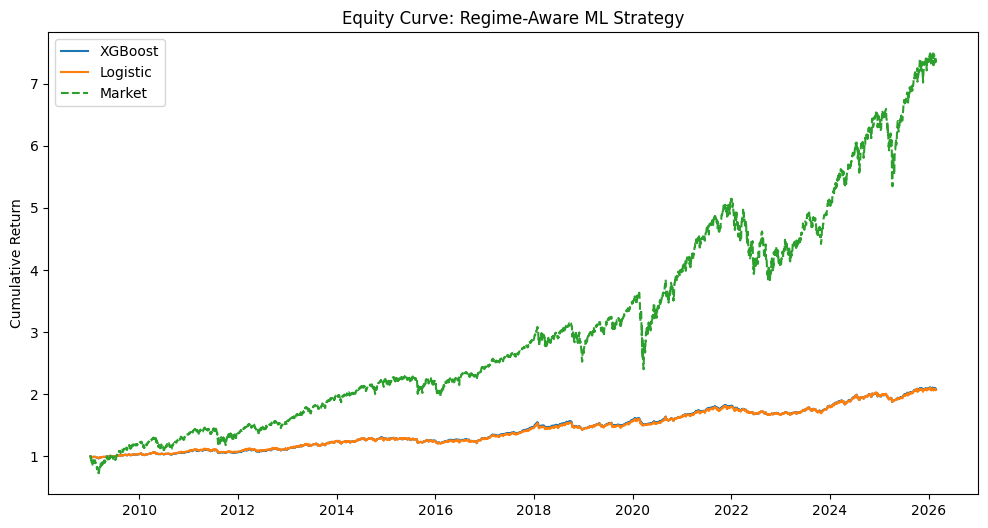

In [32]:
# ============================================================
# REGIME-AWARE ML STRATEGY WITH VOL TARGETING & SOFTER REGIME SCALING
# TRAIN: 1980-2008 • TEST: 2008-PRESENT
# XGBOOST + LOGISTIC BASELINE • SHARPE / SORTINO / CALMAR
# PUBLICATION-READY METRICS & EQUITY CURVE
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import norm

np.random.seed(42)

# ------------------------------
# 1. DOWNLOAD DATA
# ------------------------------
data = yf.download("^GSPC", start="1980-01-01", auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES
# ------------------------------
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()

data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)

# Drawdown regimes
data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

# Target: next day positive return
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = ['ret_20', 'vol_10', 'vol_20', 'trend_up', 'dd_normal', 'dd_stress', 'dd_crisis']

# ------------------------------
# 3. WALK-FORWARD TRAINING
# ------------------------------
train_end_year = 2008
data[['xgb_prob', 'logit_prob']] = np.nan

for year in data.index.year.unique():
    if year <= train_end_year:
        continue
    train = data[data.index.year <= train_end_year]
    test = data[data.index.year == year]

    X_train, y_train = train[features], train['target']
    X_test = test[features]

    # XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=250,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    data.loc[X_test.index, 'xgb_prob'] = xgb_model.predict_proba(X_test)[:,1]

    # Logistic Regression
    logit = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    logit.fit(X_train, y_train)
    data.loc[X_test.index, 'logit_prob'] = logit.predict_proba(X_test)[:,1]

# ------------------------------
# 4. VOLATILITY TARGETING
# ------------------------------
TARGET_VOL = 0.10
LOOKBACK = 20
data['realized_vol'] = data['ret'].rolling(LOOKBACK).std() * np.sqrt(252)
data['vol_scale'] = TARGET_VOL / data['realized_vol']
data['vol_scale'] = data['vol_scale'].clip(0, 1.3)  # softer cap

# ------------------------------
# 5. REGIME-SCALING (SOFTER)
# ------------------------------
def regime_scaling(row):
    base = row['vol_scale']
    if row['dd_crisis'] == 1:
        return 0.7 * base    # softer reduction
    elif row['dd_stress'] == 1:
        return 0.9 * base
    else:
        return 1.1 * base

data['regime_scale'] = data.apply(regime_scaling, axis=1)
data['xgb_alloc'] = (data['xgb_prob'] * data['regime_scale']).shift(1)
data['logit_alloc'] = (data['logit_prob'] * data['regime_scale']).shift(1)

# ------------------------------
# 6. RETURNS
# ------------------------------
data['xgb_ret'] = data['xgb_alloc'] * data['ret']
data['logit_ret'] = data['logit_alloc'] * data['ret']
data['mkt_ret'] = data['ret']
data.dropna(inplace=True)

# ------------------------------
# 7. METRICS
# ------------------------------
def sharpe(r): return r.mean()/r.std()*np.sqrt(252)
def sortino(r):
    d = r[r<0]
    return r.mean()/d.std()*np.sqrt(252) if len(d)>1 else np.nan
def calmar(r):
    eq = (1+r).cumprod()
    return r.mean()/abs((eq/eq.cummax()-1).min())
def max_dd(r):
    eq = (1+r).cumprod()
    return (eq/eq.cummax()-1).min()

# ------------------------------
# 8. OVERALL PERFORMANCE
# ------------------------------
summary = pd.DataFrame({
    'XGBoost':[sharpe(data['xgb_ret']), sortino(data['xgb_ret']), calmar(data['xgb_ret']), max_dd(data['xgb_ret'])],
    'Logistic':[sharpe(data['logit_ret']), sortino(data['logit_ret']), calmar(data['logit_ret']), max_dd(data['logit_ret'])],
    'Market':[sharpe(data['mkt_ret']), sortino(data['mkt_ret']), calmar(data['mkt_ret']), max_dd(data['mkt_ret'])]
}, index=['Sharpe','Sortino','Calmar','MaxDD'])
print("\n=== OVERALL PERFORMANCE ===")
print(summary.round(3))

# ------------------------------
# 9. REGIME LABELS
# ------------------------------
def label_regime(row):
    trend = 'Up' if row['trend_up']==1 else 'Down'
    if row['dd_crisis']==1: dd='Crisis'
    elif row['dd_stress']==1: dd='Stress'
    else: dd='Normal'
    return f"{trend}-{dd}"

data['regime'] = data.apply(label_regime, axis=1)

# ------------------------------
# 10. PUBLICATION-READY REGIME METRICS
# ------------------------------
rows=[]
for regime, subset in data.groupby('regime'):
    boot_sharpes = [sharpe(subset['xgb_ret'].sample(len(subset), replace=True)) for _ in range(1000)]
    sh_mean = np.mean(boot_sharpes)
    sh_lower = np.percentile(boot_sharpes,2.5)
    sh_upper = np.percentile(boot_sharpes,97.5)
    rows.append({
        'regime':regime,
        'xgb_sharpe':sh_mean,
        'xgb_sharpe_ci_lower':sh_lower,
        'xgb_sharpe_ci_upper':sh_upper,
        'xgb_sortino':sortino(subset['xgb_ret']),
        'xgb_calmar':calmar(subset['xgb_ret']),
        'logit_sharpe':sharpe(subset['logit_ret']),
        'market_sharpe':sharpe(subset['mkt_ret']),
        'xgb_mdd':max_dd(subset['xgb_ret']),
        'market_mdd':max_dd(subset['mkt_ret']),
        'obs':len(subset)
    })
regime_table=pd.DataFrame(rows).sort_values('obs',ascending=False)

pub_table = regime_table[['regime','xgb_sharpe','xgb_sharpe_ci_lower','xgb_sharpe_ci_upper',
                          'xgb_sortino','xgb_calmar','logit_sharpe','market_sharpe','xgb_mdd','market_mdd','obs']]
pub_table_rounded = pub_table.round(3).sort_values('regime')
print("\n=== PUBLICATION-READY REGIME METRICS ===")
print(pub_table_rounded.to_string(index=False))

# ------------------------------
# 11. SUB-PERIOD PERFORMANCE
# ------------------------------
periods = {'1980-2008':('1980-01-01','2008-12-31'),
           '2008-2015':('2008-01-01','2015-12-31'),
           '2016-present':('2016-01-01',data.index[-1].strftime('%Y-%m-%d'))}

sub=[]
for name,(s,e) in periods.items():
    d = data.loc[s:e]
    sub.append({
        'period':name,
        'xgb_sharpe':sharpe(d['xgb_ret']),
        'xgb_sortino':sortino(d['xgb_ret']),
        'xgb_calmar':calmar(d['xgb_ret']),
        'market_sharpe':sharpe(d['mkt_ret']),
        'xgb_mdd':max_dd(d['xgb_ret']),
        'market_mdd':max_dd(d['mkt_ret'])
    })
sub_df=pd.DataFrame(sub)
print("\n=== SUB-PERIOD PERFORMANCE ===")
print(sub_df.round(3))

# ------------------------------
# 12. EQUITY CURVE
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot((1+data['xgb_ret']).cumprod(), label='XGBoost')
plt.plot((1+data['logit_ret']).cumprod(), label='Logistic')
plt.plot((1+data['mkt_ret']).cumprod(), '--', label='Market')
plt.title("Equity Curve: Regime-Aware ML Strategy")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


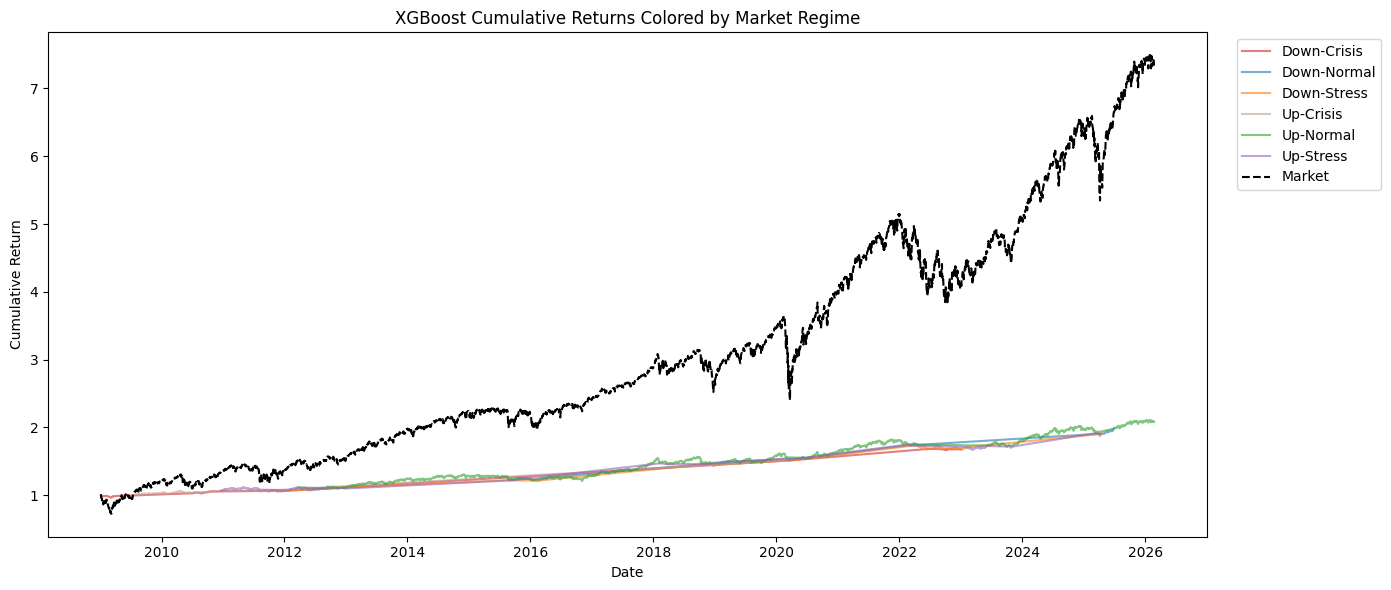

/tmp/ipykernel_18/2416258031.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=regime_sharpes.values, y=regime_sharpes.index, palette=[regime_colors[r] for r in regime_sharpes.index])


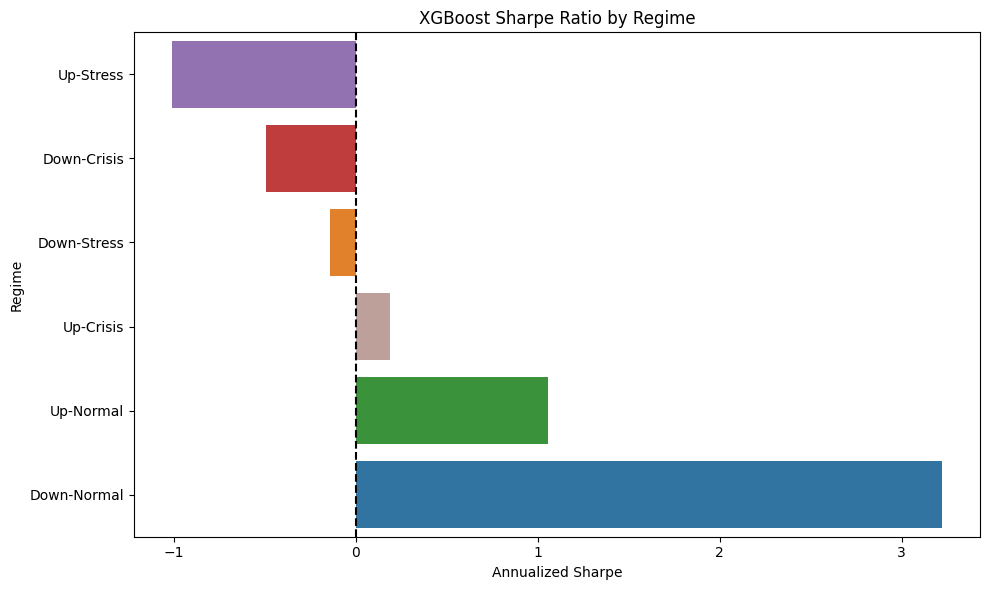

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1. CUMULATIVE RETURNS PER REGIME
# ------------------------------
data['xgb_cumret'] = (1 + data['xgb_ret']).cumprod()
data['logit_cumret'] = (1 + data['logit_ret']).cumprod()
data['mkt_cumret'] = (1 + data['mkt_ret']).cumprod()

# Map regimes to colors
regime_colors = {
    'Down-Crisis': '#d62728',   # red
    'Down-Stress': '#ff7f0e',   # orange
    'Down-Normal': '#1f77b4',   # blue
    'Up-Crisis': '#c49c94',     # brown
    'Up-Stress': '#9467bd',     # purple
    'Up-Normal': '#2ca02c'      # green
}

data['regime_color'] = data['regime'].map(regime_colors)

# ------------------------------
# 2. EQUITY CURVE WITH REGIME COLORS
# ------------------------------
plt.figure(figsize=(14,6))
for regime, group in data.groupby('regime'):
    plt.plot(group.index, group['xgb_cumret'], color=regime_colors[regime], alpha=0.6, label=regime)

plt.plot(data.index, data['mkt_cumret'], '--', color='black', label='Market', linewidth=1.5)
plt.title("XGBoost Cumulative Returns Colored by Market Regime")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

# ------------------------------
# 3. REGIME-WISE SHARPE BAR CHART
# ------------------------------
# Compute regime-wise Sharpe ratios for XGBoost
regime_sharpes = data.groupby('regime')['xgb_ret'].apply(lambda r: r.mean()/r.std()*np.sqrt(252))
regime_sharpes = regime_sharpes.sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=regime_sharpes.values, y=regime_sharpes.index, palette=[regime_colors[r] for r in regime_sharpes.index])
plt.axvline(0, color='black', linestyle='--')
plt.title("XGBoost Sharpe Ratio by Regime")
plt.xlabel("Annualized Sharpe")
plt.ylabel("Regime")
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_18/2503363190.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['xgb_prob'] = xgb_model.predict_proba(test[features])[:,1]
/tmp/ipykernel_18/2503363190.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['logit_prob'] = logit.predict_proba(test[features])[:,1]
/tmp/ipykernel_18/2503363190.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe


=== VOL TARGET & REGIME SCALING SENSITIVITY ===
   TARGET_VOL  REGIME_NORMAL  REGIME_STRESS  REGIME_CRISIS  XGB_Sharpe  \
0        0.05            1.0            0.8            0.5       0.699   
1        0.05            1.2            1.0            0.6       0.713   
2        0.05            0.8            0.6            0.4       0.705   
3        0.10            1.0            0.8            0.5       0.725   
4        0.10            1.2            1.0            0.6       0.723   
5        0.10            0.8            0.6            0.4       0.724   
6        0.15            1.0            0.8            0.5       0.770   
7        0.15            1.2            1.0            0.6       0.765   
8        0.15            0.8            0.6            0.4       0.760   

   XGB_Sortino  XGB_MaxDD  Market_Sharpe  Market_MaxDD  
0        0.824     -0.046          0.784        -0.339  
1        0.842     -0.056          0.848        -0.339  
2        0.828     -0.037          0.82

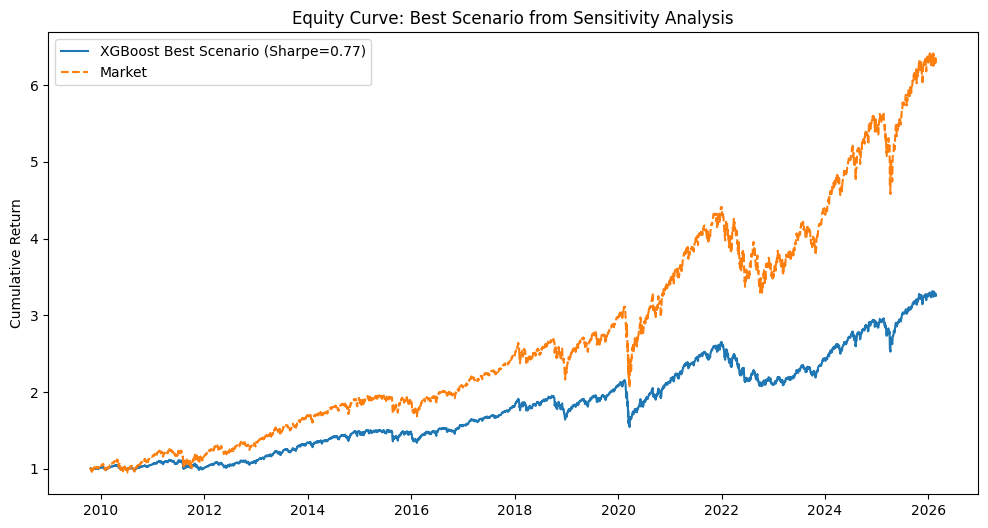

In [34]:
# ============================================================
# AUTOMATIC VOL TARGETING & REGIME SCALING SENSITIVITY
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(42)

# ------------------------------
# 1. DATA
# ------------------------------
data = yf.download("^GSPC", start="1980-01-01", auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)
data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# Features
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()
data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)

# Drawdown regimes
data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']
data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

# Target
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = ['ret_20','vol_10','vol_20','trend_up','dd_normal','dd_stress','dd_crisis']

# ------------------------------
# 2. TRAIN XGBoost & LOGISTIC
# ------------------------------
train_end = '2008-12-31'
train = data.loc[:train_end]
test = data.loc['2009-01-01':]

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(train[features], train['target'])
test['xgb_prob'] = xgb_model.predict_proba(test[features])[:,1]

# Logistic
logit = Pipeline([('scaler', StandardScaler()),('clf', LogisticRegression(max_iter=1000))])
logit.fit(train[features], train['target'])
test['logit_prob'] = logit.predict_proba(test[features])[:,1]

# ------------------------------
# 3. PERFORMANCE METRICS
# ------------------------------
def sharpe(r): return r.mean()/r.std()*np.sqrt(252)
def sortino(r):
    d = r[r<0]
    return r.mean()/d.std()*np.sqrt(252) if len(d)>1 else np.nan
def max_dd(r): return ( (1+r).cumprod()/ (1+r).cumprod().cummax() - 1 ).min()

# ------------------------------
# 4. SENSITIVITY ANALYSIS
# ------------------------------
TARGET_VOL_LIST = [0.05, 0.10, 0.15]   # example volatility targets
REGIME_SCALING_LIST = [
    {'normal':1.0,'stress':0.8,'crisis':0.5},
    {'normal':1.2,'stress':1.0,'crisis':0.6},
    {'normal':0.8,'stress':0.6,'crisis':0.4}
]

results = []

for vol in TARGET_VOL_LIST:
    for scale_dict in REGIME_SCALING_LIST:
        # Vol targeting
        LOOKBACK = 20
        test['realized_vol'] = test['ret'].rolling(LOOKBACK).std() * np.sqrt(252)
        test['vol_scale'] = (vol / test['realized_vol']).clip(0,1.5)
        
        # Regime scaling
        def regime_scale(row):
            if row['dd_crisis']==1: return scale_dict['crisis']*row['vol_scale']
            if row['dd_stress']==1: return scale_dict['stress']*row['vol_scale']
            return scale_dict['normal']*row['vol_scale']
        test['regime_scale'] = test.apply(regime_scale,axis=1)
        test['xgb_alloc'] = (test['xgb_prob']*test['regime_scale']).shift(1)
        test['logit_alloc'] = (test['logit_prob']*test['regime_scale']).shift(1)
        
        # Returns
        test['xgb_ret'] = test['xgb_alloc']*test['ret']
        test['logit_ret'] = test['logit_alloc']*test['ret']
        test['mkt_ret'] = test['ret']
        test.dropna(inplace=True)
        
        # Metrics
        results.append({
            'TARGET_VOL': vol,
            'REGIME_NORMAL': scale_dict['normal'],
            'REGIME_STRESS': scale_dict['stress'],
            'REGIME_CRISIS': scale_dict['crisis'],
            'XGB_Sharpe': sharpe(test['xgb_ret']),
            'XGB_Sortino': sortino(test['xgb_ret']),
            'XGB_MaxDD': max_dd(test['xgb_ret']),
            'Market_Sharpe': sharpe(test['mkt_ret']),
            'Market_MaxDD': max_dd(test['mkt_ret'])
        })

sens_df = pd.DataFrame(results)
print("\n=== VOL TARGET & REGIME SCALING SENSITIVITY ===")
print(sens_df.round(3))

# ------------------------------
# 5. OPTIONAL: EQUITY CURVES FOR BEST SCENARIO
# ------------------------------
best_idx = sens_df['XGB_Sharpe'].idxmax()
best_vol = sens_df.loc[best_idx,'TARGET_VOL']
best_scale = {
    'normal':sens_df.loc[best_idx,'REGIME_NORMAL'],
    'stress':sens_df.loc[best_idx,'REGIME_STRESS'],
    'crisis':sens_df.loc[best_idx,'REGIME_CRISIS']
}

# Apply best scenario
test['vol_scale'] = (best_vol / test['ret'].rolling(20).std() * np.sqrt(252)).clip(0,1.5)
def regime_scale(row):
    if row['dd_crisis']==1: return best_scale['crisis']*row['vol_scale']
    if row['dd_stress']==1: return best_scale['stress']*row['vol_scale']
    return best_scale['normal']*row['vol_scale']
test['regime_scale'] = test.apply(regime_scale,axis=1)
test['xgb_alloc'] = (test['xgb_prob']*test['regime_scale']).shift(1)
test['xgb_ret'] = test['xgb_alloc']*test['ret']
test.dropna(inplace=True)

plt.figure(figsize=(12,6))
plt.plot((1+test['xgb_ret']).cumprod(), label=f'XGBoost Best Scenario (Sharpe={sens_df.loc[best_idx,"XGB_Sharpe"]:.2f})')
plt.plot((1+test['mkt_ret']).cumprod(), '--', label='Market')
plt.title("Equity Curve: Best Scenario from Sensitivity Analysis")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


# Final code

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_18/436847311.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]
/tmp/ipykernel_18/436847311.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['logit_prob'] = logit.predict_proba(X_test)[:, 1]
/tmp/ipykernel_18/436847311.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 


=== BEST XGBOOST CONFIGURATION ===
TARGET_VOL       0.150
REGIME_NORMAL    0.800
REGIME_STRESS    0.800
REGIME_CRISIS    0.600
XGB_Sharpe       0.815
XGB_Sortino      1.025
XGB_MaxDD       -0.094
Logit_Sharpe     0.821
Logit_Sortino    1.047
Logit_MaxDD     -0.085
Market_Sharpe    0.751
Market_MaxDD    -0.339
Name: 59, dtype: float64

=== BEST LOGISTIC REGRESSION CONFIGURATION ===
TARGET_VOL       0.150
REGIME_NORMAL    0.800
REGIME_STRESS    0.800
REGIME_CRISIS    0.600
XGB_Sharpe       0.815
XGB_Sortino      1.025
XGB_MaxDD       -0.094
Logit_Sharpe     0.821
Logit_Sortino    1.047
Logit_MaxDD     -0.085
Market_Sharpe    0.751
Market_MaxDD    -0.339
Name: 59, dtype: float64


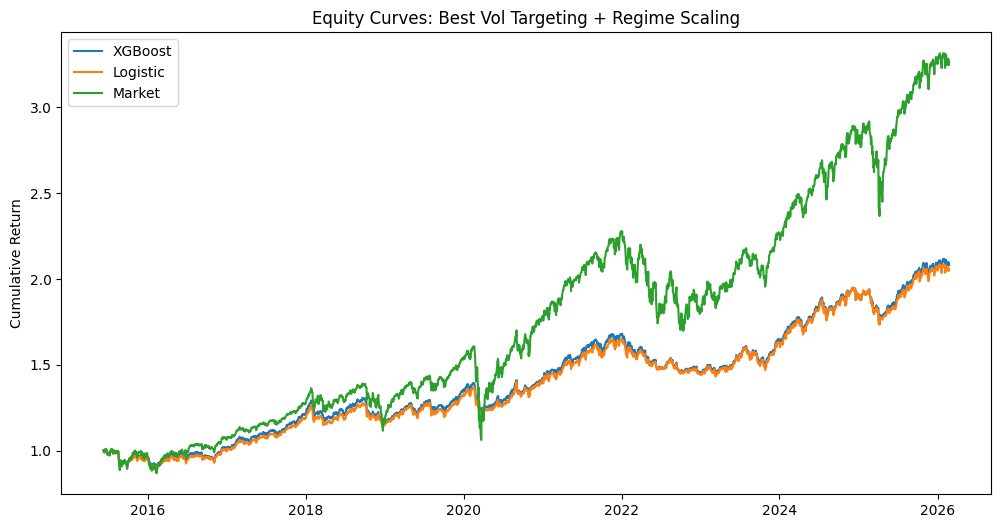


=== VOL TARGET & REGIME SCALING SENSITIVITY ===
 TARGET_VOL  REGIME_NORMAL  REGIME_STRESS  REGIME_CRISIS  XGB_Sharpe  XGB_Sortino  XGB_MaxDD  Logit_Sharpe  Logit_Sortino  Logit_MaxDD  Market_Sharpe  Market_MaxDD
       0.05            0.8            0.6            0.4       0.699        0.821     -0.037         0.712          0.854       -0.032          0.784        -0.339
       0.05            0.8            0.6            0.5       0.739        0.876     -0.037         0.751          0.909       -0.032          0.848        -0.339
       0.05            0.8            0.6            0.6       0.751        0.894     -0.037         0.765          0.932       -0.032          0.822        -0.339
       0.05            0.8            0.8            0.4       0.700        0.834     -0.039         0.717          0.873       -0.036          0.800        -0.339
       0.05            0.8            0.8            0.5       0.721        0.864     -0.039         0.738          0.905       -0.

In [35]:
# ============================================================
# REGIME-AWARE ML STRATEGY • VOL TARGETING & REGIME SCALING SENSITIVITY
# XGBoost + Logistic Regression • Publication-ready metrics
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product
from scipy.stats import norm

np.random.seed(42)

# ------------------------------
# 1. DATA
# ------------------------------
data = yf.download("^GSPC", start="1980-01-01", auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES & REGIMES
# ------------------------------
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()
data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)
data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

# Target
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = ['ret_20', 'vol_10', 'vol_20', 'trend_up', 'dd_normal', 'dd_stress', 'dd_crisis']

# ------------------------------
# 3. WALK-FORWARD TRAINING
# ------------------------------
years = data.index.year.unique()
train_end_year = 2008
test_start_year = train_end_year + 1

train = data[data.index.year <= train_end_year]
test = data[data.index.year >= test_start_year]

X_train, y_train = train[features], train['target']
X_test, y_test = test[features], test['target']

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=250, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42
)
xgb_model.fit(X_train, y_train)
test['xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]

# Logistic Regression
logit = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))])
logit.fit(X_train, y_train)
test['logit_prob'] = logit.predict_proba(X_test)[:, 1]

# ------------------------------
# 4. VOL TARGET & REGIME SCALING GRID
# ------------------------------
TARGET_VOL_GRID = [0.05, 0.10, 0.15]
REGIME_NORMAL_GRID = [0.8, 1.0, 1.2]
REGIME_STRESS_GRID = [0.6, 0.8, 1.0]
REGIME_CRISIS_GRID = [0.4, 0.5, 0.6]

results = []

for vol_target, normal_scale, stress_scale, crisis_scale in product(
    TARGET_VOL_GRID, REGIME_NORMAL_GRID, REGIME_STRESS_GRID, REGIME_CRISIS_GRID
):
    # Vol targeting
    LOOKBACK = 20
    test['realized_vol'] = test['ret'].rolling(LOOKBACK).std() * np.sqrt(252)
    test['vol_scale'] = vol_target / test['realized_vol']
    test['vol_scale'] = test['vol_scale'].clip(0, 1.5)
    
    # Regime scaling
    def regime_scale(row):
        base = row['vol_scale']
        if row['dd_crisis'] == 1:
            return crisis_scale * base
        elif row['dd_stress'] == 1:
            return stress_scale * base
        else:
            return normal_scale * base
    test['regime_scale'] = test.apply(regime_scale, axis=1)
    
    # Apply allocations
    test['xgb_alloc'] = (test['xgb_prob'] * test['regime_scale']).shift(1)
    test['logit_alloc'] = (test['logit_prob'] * test['regime_scale']).shift(1)
    test.dropna(inplace=True)
    
    # Returns
    test['xgb_ret'] = test['xgb_alloc'] * test['ret']
    test['logit_ret'] = test['logit_alloc'] * test['ret']
    
    # Metrics
    def sharpe(r): return r.mean() / r.std() * np.sqrt(252)
    def sortino(r): 
        d = r[r < 0]
        return r.mean() / d.std() * np.sqrt(252) if len(d) > 1 else np.nan
    def max_dd(r):
        eq = (1 + r).cumprod()
        return (eq / eq.cummax() - 1).min()
    
    results.append({
        'TARGET_VOL': vol_target,
        'REGIME_NORMAL': normal_scale,
        'REGIME_STRESS': stress_scale,
        'REGIME_CRISIS': crisis_scale,
        'XGB_Sharpe': sharpe(test['xgb_ret']),
        'XGB_Sortino': sortino(test['xgb_ret']),
        'XGB_MaxDD': max_dd(test['xgb_ret']),
        'Logit_Sharpe': sharpe(test['logit_ret']),
        'Logit_Sortino': sortino(test['logit_ret']),
        'Logit_MaxDD': max_dd(test['logit_ret']),
        'Market_Sharpe': sharpe(test['ret']),
        'Market_MaxDD': max_dd(test['ret'])
    })

sensitivity_df = pd.DataFrame(results)

# ------------------------------
# 5. BEST CONFIGS
# ------------------------------
best_xgb = sensitivity_df.loc[sensitivity_df['XGB_Sharpe'].idxmax()]
best_logit = sensitivity_df.loc[sensitivity_df['Logit_Sharpe'].idxmax()]

print("\n=== BEST XGBOOST CONFIGURATION ===")
print(best_xgb.round(3))

print("\n=== BEST LOGISTIC REGRESSION CONFIGURATION ===")
print(best_logit.round(3))

# ------------------------------
# 6. EQUITY CURVES
# ------------------------------
plt.figure(figsize=(12,6))
for alloc_col, label in [('xgb_ret','XGBoost'), ('logit_ret','Logistic'), ('ret','Market')]:
    plt.plot((1 + test[alloc_col]).cumprod(), label=label)
plt.title("Equity Curves: Best Vol Targeting + Regime Scaling")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# ------------------------------
# 7. PUBLICATION-READY TABLE
# ------------------------------
pub_table = sensitivity_df[['TARGET_VOL','REGIME_NORMAL','REGIME_STRESS','REGIME_CRISIS',
                            'XGB_Sharpe','XGB_Sortino','XGB_MaxDD',
                            'Logit_Sharpe','Logit_Sortino','Logit_MaxDD',
                            'Market_Sharpe','Market_MaxDD']].round(3)

print("\n=== VOL TARGET & REGIME SCALING SENSITIVITY ===")
print(pub_table.to_string(index=False))


### added sortino ratios

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_18/1489000662.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]
/tmp/ipykernel_18/1489000662.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['logit_prob'] = logit.predict_proba(X_test)[:, 1]
/tmp/ipykernel_18/1489000662.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]


=== BEST XGBOOST CONFIGURATION ===
TARGET_VOL        0.150
REGIME_NORMAL     0.800
REGIME_STRESS     0.800
REGIME_CRISIS     0.600
XGB_Sharpe        0.815
XGB_Sortino       1.025
XGB_MaxDD        -0.094
Logit_Sharpe      0.821
Logit_Sortino     1.047
Logit_MaxDD      -0.085
Market_Sharpe     0.751
Market_Sortino    0.915
Market_MaxDD     -0.339
Name: 59, dtype: float64

=== BEST LOGISTIC REGRESSION CONFIGURATION ===
TARGET_VOL        0.150
REGIME_NORMAL     0.800
REGIME_STRESS     0.800
REGIME_CRISIS     0.600
XGB_Sharpe        0.815
XGB_Sortino       1.025
XGB_MaxDD        -0.094
Logit_Sharpe      0.821
Logit_Sortino     1.047
Logit_MaxDD      -0.085
Market_Sharpe     0.751
Market_Sortino    0.915
Market_MaxDD     -0.339
Name: 59, dtype: float64


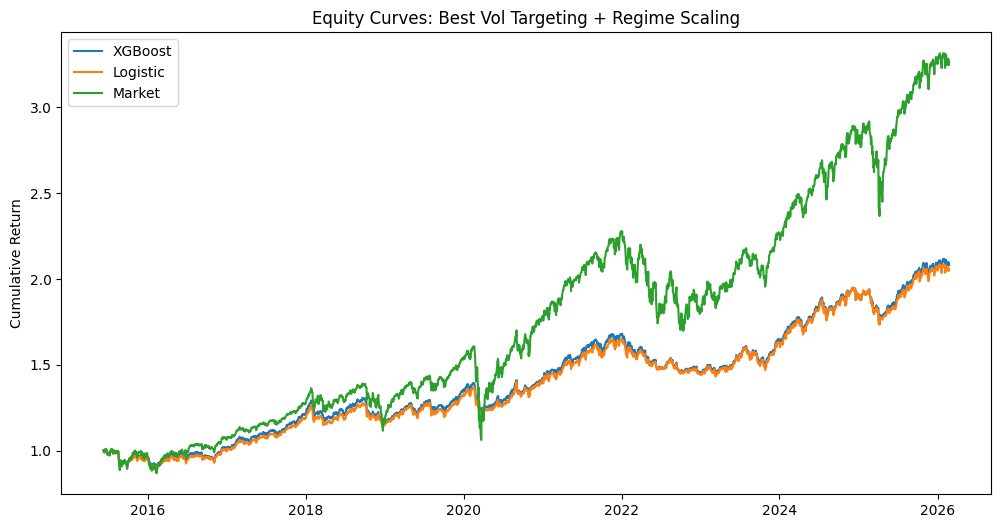


=== VOL TARGET & REGIME SCALING SENSITIVITY ===
 TARGET_VOL  REGIME_NORMAL  REGIME_STRESS  REGIME_CRISIS  XGB_Sharpe  XGB_Sortino  XGB_MaxDD  Logit_Sharpe  Logit_Sortino  Logit_MaxDD  Market_Sharpe  Market_Sortino  Market_MaxDD
       0.05            0.8            0.6            0.4       0.699        0.821     -0.037         0.712          0.854       -0.032          0.784           0.976        -0.339
       0.05            0.8            0.6            0.5       0.739        0.876     -0.037         0.751          0.909       -0.032          0.848           1.062        -0.339
       0.05            0.8            0.6            0.6       0.751        0.894     -0.037         0.765          0.932       -0.032          0.822           1.020        -0.339
       0.05            0.8            0.8            0.4       0.700        0.834     -0.039         0.717          0.873       -0.036          0.800           0.993        -0.339
       0.05            0.8            0.8          

In [36]:
# ============================================================
# REGIME-AWARE ML STRATEGY • VOL TARGETING & REGIME SCALING SENSITIVITY
# XGBoost + Logistic Regression • Publication-ready metrics
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product

np.random.seed(42)

# ------------------------------
# 1. DATA
# ------------------------------
data = yf.download("^GSPC", start="1980-01-01", auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data['price'] = data['Close']
data['ret'] = data['price'].pct_change()

# ------------------------------
# 2. FEATURES & REGIMES
# ------------------------------
data['ret_20'] = data['ret'].rolling(20).mean()
data['vol_10'] = data['ret'].rolling(10).std()
data['vol_20'] = data['ret'].rolling(20).std()
data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()
data['trend_up'] = (data['ma_50'] > data['ma_200']).astype(int)
data['rolling_max'] = data['price'].cummax()
data['drawdown'] = (data['price'] - data['rolling_max']) / data['rolling_max']

data['dd_normal'] = (data['drawdown'] > -0.10).astype(int)
data['dd_stress'] = ((data['drawdown'] <= -0.10) & (data['drawdown'] > -0.20)).astype(int)
data['dd_crisis'] = (data['drawdown'] <= -0.20).astype(int)

# Target
data['target'] = (data['ret'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = ['ret_20', 'vol_10', 'vol_20', 'trend_up', 'dd_normal', 'dd_stress', 'dd_crisis']

# ------------------------------
# 3. WALK-FORWARD TRAINING
# ------------------------------
train_end_year = 2008
test_start_year = train_end_year + 1

train = data[data.index.year <= train_end_year]
test = data[data.index.year >= test_start_year]

X_train, y_train = train[features], train['target']
X_test, y_test = test[features], test['target']

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=250, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42
)
xgb_model.fit(X_train, y_train)
test['xgb_prob'] = xgb_model.predict_proba(X_test)[:, 1]

# Logistic Regression
logit = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))])
logit.fit(X_train, y_train)
test['logit_prob'] = logit.predict_proba(X_test)[:, 1]

# ------------------------------
# 4. VOL TARGET & REGIME SCALING GRID
# ------------------------------
TARGET_VOL_GRID = [0.05, 0.10, 0.15]
REGIME_NORMAL_GRID = [0.8, 1.0, 1.2]
REGIME_STRESS_GRID = [0.6, 0.8, 1.0]
REGIME_CRISIS_GRID = [0.4, 0.5, 0.6]

results = []

for vol_target, normal_scale, stress_scale, crisis_scale in product(
    TARGET_VOL_GRID, REGIME_NORMAL_GRID, REGIME_STRESS_GRID, REGIME_CRISIS_GRID
):
    # Vol targeting
    LOOKBACK = 20
    test['realized_vol'] = test['ret'].rolling(LOOKBACK).std() * np.sqrt(252)
    test['vol_scale'] = vol_target / test['realized_vol']
    test['vol_scale'] = test['vol_scale'].clip(0, 1.5)
    
    # Regime scaling
    def regime_scale(row):
        base = row['vol_scale']
        if row['dd_crisis'] == 1:
            return crisis_scale * base
        elif row['dd_stress'] == 1:
            return stress_scale * base
        else:
            return normal_scale * base
    test['regime_scale'] = test.apply(regime_scale, axis=1)
    
    # Apply allocations
    test['xgb_alloc'] = (test['xgb_prob'] * test['regime_scale']).shift(1)
    test['logit_alloc'] = (test['logit_prob'] * test['regime_scale']).shift(1)
    test.dropna(inplace=True)
    
    # Returns
    test['xgb_ret'] = test['xgb_alloc'] * test['ret']
    test['logit_ret'] = test['logit_alloc'] * test['ret']
    
    # Metrics
    def sharpe(r): 
        return r.mean() / r.std() * np.sqrt(252)
    
    def sortino(r): 
        d = r[r < 0]
        return r.mean() / d.std() * np.sqrt(252) if len(d) > 1 else np.nan
    
    def max_dd(r):
        eq = (1 + r).cumprod()
        return (eq / eq.cummax() - 1).min()
    
    results.append({
        'TARGET_VOL': vol_target,
        'REGIME_NORMAL': normal_scale,
        'REGIME_STRESS': stress_scale,
        'REGIME_CRISIS': crisis_scale,
        'XGB_Sharpe': sharpe(test['xgb_ret']),
        'XGB_Sortino': sortino(test['xgb_ret']),
        'XGB_MaxDD': max_dd(test['xgb_ret']),
        'Logit_Sharpe': sharpe(test['logit_ret']),
        'Logit_Sortino': sortino(test['logit_ret']),
        'Logit_MaxDD': max_dd(test['logit_ret']),
        'Market_Sharpe': sharpe(test['ret']),
        'Market_Sortino': sortino(test['ret']),
        'Market_MaxDD': max_dd(test['ret'])
    })

sensitivity_df = pd.DataFrame(results)

# ------------------------------
# 5. BEST CONFIGS
# ------------------------------
best_xgb = sensitivity_df.loc[sensitivity_df['XGB_Sharpe'].idxmax()]
best_logit = sensitivity_df.loc[sensitivity_df['Logit_Sharpe'].idxmax()]

print("\n=== BEST XGBOOST CONFIGURATION ===")
print(best_xgb.round(3))

print("\n=== BEST LOGISTIC REGRESSION CONFIGURATION ===")
print(best_logit.round(3))

# ------------------------------
# 6. EQUITY CURVES
# ------------------------------
plt.figure(figsize=(12,6))
for alloc_col, label in [('xgb_ret','XGBoost'), ('logit_ret','Logistic'), ('ret','Market')]:
    plt.plot((1 + test[alloc_col]).cumprod(), label=label)
plt.title("Equity Curves: Best Vol Targeting + Regime Scaling")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# ------------------------------
# 7. PUBLICATION-READY TABLE
# ------------------------------
pub_table = sensitivity_df[['TARGET_VOL','REGIME_NORMAL','REGIME_STRESS','REGIME_CRISIS',
                            'XGB_Sharpe','XGB_Sortino','XGB_MaxDD',
                            'Logit_Sharpe','Logit_Sortino','Logit_MaxDD',
                            'Market_Sharpe','Market_Sortino','Market_MaxDD']].round(3)

print("\n=== VOL TARGET & REGIME SCALING SENSITIVITY ===")
print(pub_table.to_string(index=False))